In [1]:
import os
import pandas as pd
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import auth
import gspread
import pandas as pd
from google.auth import default

# Authenticate the Google account
auth.authenticate_user()

# Authorize access
creds, _ = default()
gc = gspread.authorize(creds)

# Use the link you provided to open the Google Sheet
spreadsheet_url = 'https://docs.google.com/spreadsheets/d/16j7vgw-M5tCmzqoPk0QwsvC0fnAU0fNyyYM1qy1vDZg/edit?gid=0#gid=0'

# Open the spreadsheet
spreadsheet = gc.open_by_url(spreadsheet_url)

# Select the first worksheet
worksheet = spreadsheet.sheet1

# Get all the data and convert it to a pandas DataFrame
data = worksheet.get_all_records()
df = pd.DataFrame(data)

# Display the first few rows of the DataFrame
df.head()

DMA / Location  CHICAGO  DETROIT  WASHINGTON,DC  COLUMBUS,OH  BALTIMORE  \
0         Aug-23    41380    33640          34100        22660      22800   
1         Sep-23    41280    33460          27770        18440      18700   
2         Oct-23    41280    33480          27790        18490      18570   
3         Nov-23    50440    40920          41350        27510      27710   
4         Dec-23    41050    33430          27790        18410      18640   

   ATLANTA  CLEVELAND  ST LOUIS  TAMPA  ...  LANSING  FT WAYNE  YOUNGSTOWN  \
0    24660      27480     15050   6580  ...     2440      2960        2940   
1    23850      22500     14980   6440  ...     2460      2960        2950   
2    23820      22520     15000   5400  ...     2430      2930        2950   
3    29410      27530     18340   8090  ...     3650      4440        3650   
4    19860      22500     15030   6440  ...     2930      2950        2960   

   TRAVERSE CITY  WHEELING  SOUTH BEND  EVANSVILLE  CHARLESTON,WV  \
0           1330      1930        3670        2460           2950   
1           1330      1620        2980        1640           2430   
2           1320      1630        3690        1660           2450   
3           1630      2430        4470        2450           2970   
4           1320      1920        3670        1970           2930   

   PARKERSBURG   TOTAL  
0          910  403740  
1          900  367730  
2          910  365080  
3         1020  483160  
4          910  363190  

[5 rows x 42 columns]

## Data Preprocessing


In [3]:
print(df.shape)
print(df.columns)
df.set_index('DMA / Location', inplace=True)
df
overall_search = df.iloc[:,-1]
overall_search

(12, 42)
Index(['DMA / Location', 'CHICAGO', 'DETROIT', 'WASHINGTON,DC', 'COLUMBUS,OH',
       'BALTIMORE', 'ATLANTA', 'CLEVELAND', 'ST LOUIS', 'TAMPA', 'NORFOLK',
       'PITTSBURGH', 'CHARLOTTE', 'CINCINNATI', 'INDIANAPOLIS', 'NASHVILLE',
       'LOUISVILLE', 'ORLANDO', 'TOLEDO', 'GRAND RAPIDS', 'DAYTON',
       'COLUMBIA,SC', 'JACKSONVILLE', 'FLINT', 'BUFFALO', 'HARRISBURG',
       'LEXINGTON', 'ROCHESTER,NY', 'FT MYERS', 'MIAMI', 'RICHMOND',
       'PHILADELPHIA', 'LANSING', 'FT WAYNE', 'YOUNGSTOWN', 'TRAVERSE CITY',
       'WHEELING', 'SOUTH BEND', 'EVANSVILLE', 'CHARLESTON,WV', 'PARKERSBURG',
       'TOTAL'],
      dtype='object')


DMA / Location
Aug-23    403740
Sep-23    367730
Oct-23    365080
Nov-23    483160
Dec-23    363190
Jan-24    457030
Feb-24    460580
Mar-24    458540
Apr-24    365600
May-24    419210
Jun-24    375050
Jul-24    436400
Name: TOTAL, dtype: int64

In [4]:
overall_search = df.iloc[:,-1]
overall_search

DMA / Location
Aug-23    403740
Sep-23    367730
Oct-23    365080
Nov-23    483160
Dec-23    363190
Jan-24    457030
Feb-24    460580
Mar-24    458540
Apr-24    365600
May-24    419210
Jun-24    375050
Jul-24    436400
Name: TOTAL, dtype: int64

Forecasting

In [5]:
#need to split the data into train and test
# test set is last 3 months
train_rows=overall_search.iloc[:-3]
test_rows=overall_search.iloc[-3:]

In [7]:
import datetime

# we need to do this because this will convert it to a date time object
# then we convert this to a dataframe
X_train=[datetime.datetime.strptime(x.strip(), '%b-%y') for x in train_rows.index]

# y_train= train_rows.to_numpy()
X_train_df= pd.DataFrame(X_train)
y_train=train_rows.apply(pd.to_numeric, errors = 'coerce')




X_test = [datetime.datetime.strptime(x.strip(), '%b-%y') for x in test_rows.index]
# y_test = test_rows.to_numpy()
X_test_df= pd.DataFrame(X_test)
y_test = test_rows.apply(pd.to_numeric, errors = 'coerce')


y_train


DMA / Location
Aug-23    403740
Sep-23    367730
Oct-23    365080
Nov-23    483160
Dec-23    363190
Jan-24    457030
Feb-24    460580
Mar-24    458540
Apr-24    365600
Name: TOTAL, dtype: int64

In [8]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

p = lag
q = residual errors, short term shocks/fluctuations
i = number of differencing (linear, quadratic, etc)

## For ASI next 6 month overall

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


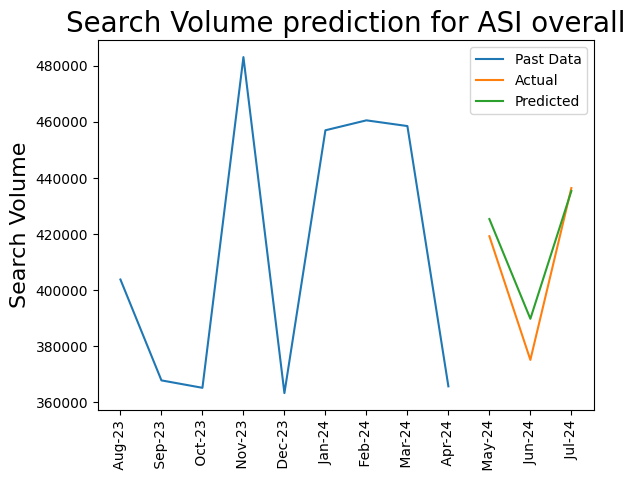

In [9]:
sarima = SARIMAX(y_train.to_numpy(),
                 order=(3, 0, 2),
                 seasonal_order = (2,0,2,12)).fit() # 12 beacause each season is around a year
predictions = sarima.forecast(steps = 3)


overall_preds = []
overall_preds.append(predictions)
predictions = pd.Series(predictions, index = y_test.index)

plt.plot(y_train, label = "Past Data")
plt.plot(y_test, label="Actual")
plt.plot(predictions, label="Predicted")
plt.title('Search Volume prediction for ASI overall', fontsize=20)
plt.ylabel('Search Volume', fontsize=16)
plt.xticks(rotation = 90)
plt.legend()
plt.show()

In [10]:
sarima = SARIMAX(y_train.to_numpy(),
                 order=(3, 0, 2),
                 seasonal_order = (2,0,2,12)).fit() # 12 beacause each season is around a year
predictions = sarima.forecast(steps = 9)




/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## For ASI individual DMA performance

In [11]:
#need to split the data into train and test
# test set is last 3 months
train_rows=df.iloc[:-3]
test_rows=df[-3:]

import datetime

# we need to do this because this will convert it to a date time object
# then we convert this to a dataframe
X_train=[datetime.datetime.strptime(x.strip(), '%b-%y') for x in train_rows.index]

# y_train= train_rows.to_numpy()
X_train_df= pd.DataFrame(X_train)
y_train=train_rows.apply(pd.to_numeric, errors = 'coerce')




X_test = [datetime.datetime.strptime(x.strip(), '%b-%y') for x in test_rows.index]
# y_test = test_rows.to_numpy()
X_test_df= pd.DataFrame(X_test)
y_test = test_rows.apply(pd.to_numeric, errors = 'coerce')


y_test


CHICAGO  DETROIT  WASHINGTON,DC  COLUMBUS,OH  BALTIMORE  \
DMA / Location                                                            
May-24            50190    33370          33770        22520      22630   
Jun-24            41290    33400          27790        18460      18530   
Jul-24            50160    33420          33760        22550      22630   

                ATLANTA  CLEVELAND  ST LOUIS  TAMPA  NORFOLK  ...  LANSING  \
DMA / Location                                                ...            
May-24            24230      27330     18260   7720    12300  ...     2440   
Jun-24            24740      22510     15030   7680    10100  ...     1950   
Jul-24            26690      22510     18270   9560    12310  ...     2440   

                FT WAYNE  YOUNGSTOWN  TRAVERSE CITY  WHEELING  SOUTH BEND  \
DMA / Location                                                              
May-24              2960        2920           1630      1610        2960   
Jun-24              2940        2440           1650      1310        2960   
Jul-24              2950        2940           1640      1620        2950   

                EVANSVILLE  CHARLESTON,WV  PARKERSBURG   TOTAL  
DMA / Location                                                  
May-24                1950           2470          730  419210  
Jun-24                1980           2450          740  375050  
Jul-24                2460           2950          890  436400  

[3 rows x 41 columns]

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


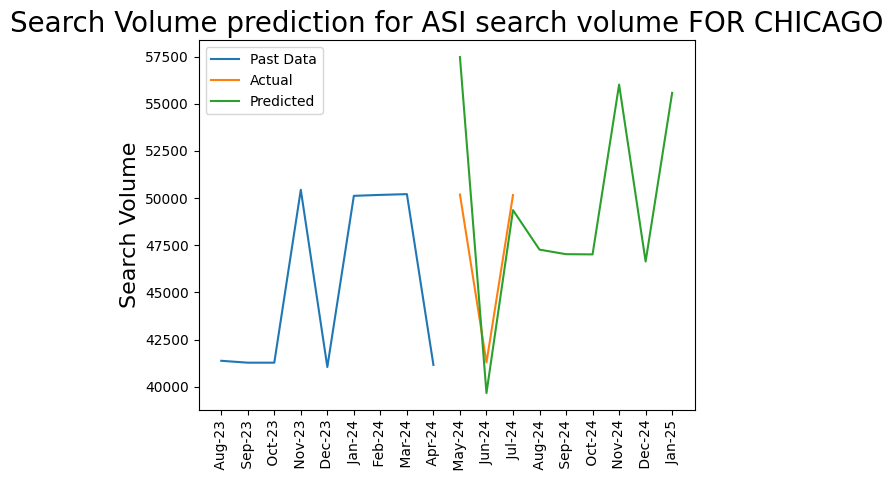

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


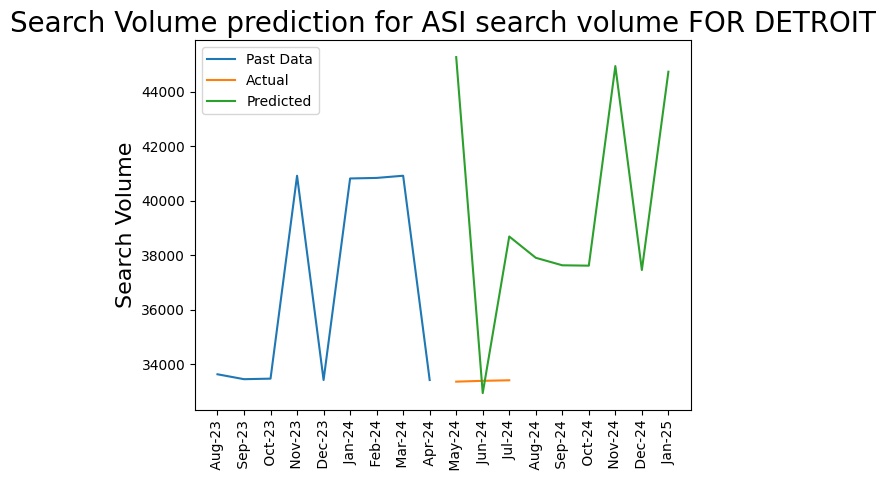

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


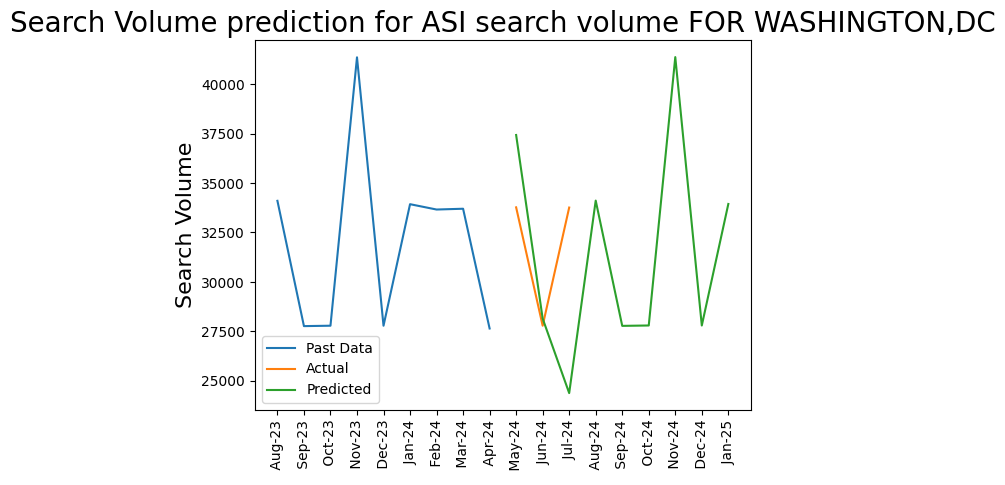

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


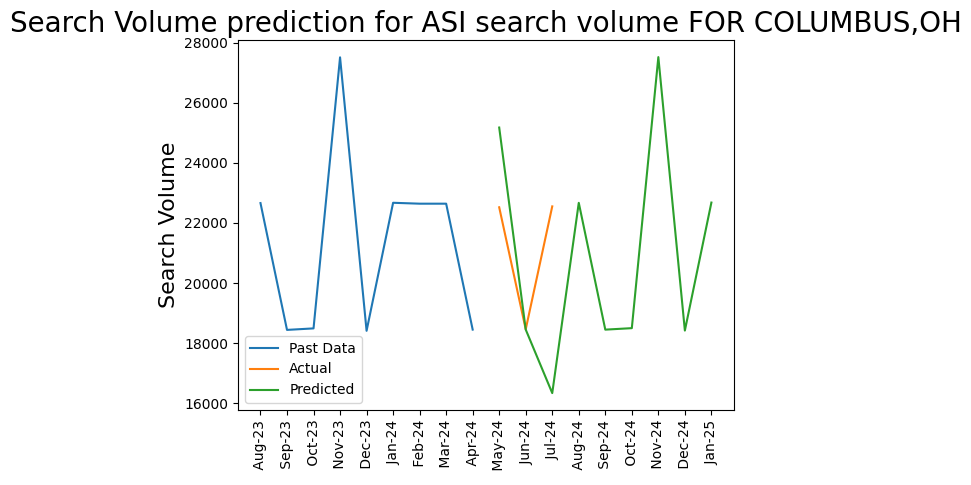

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


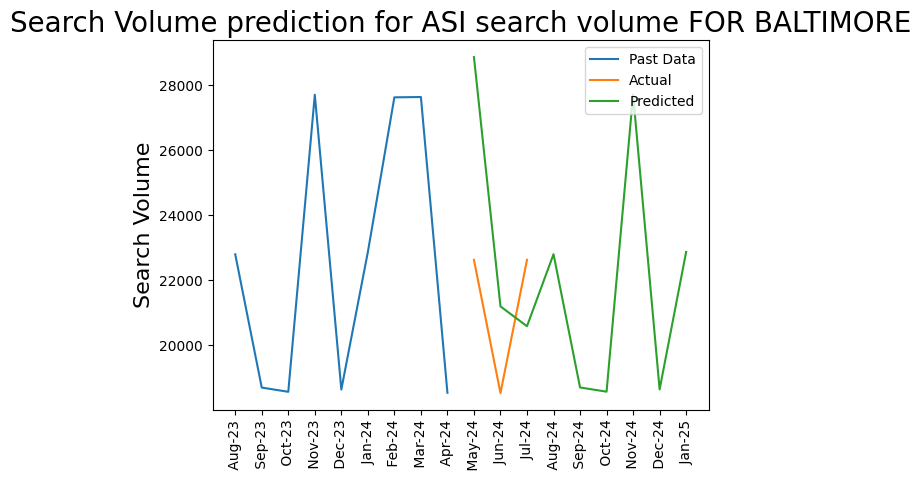

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


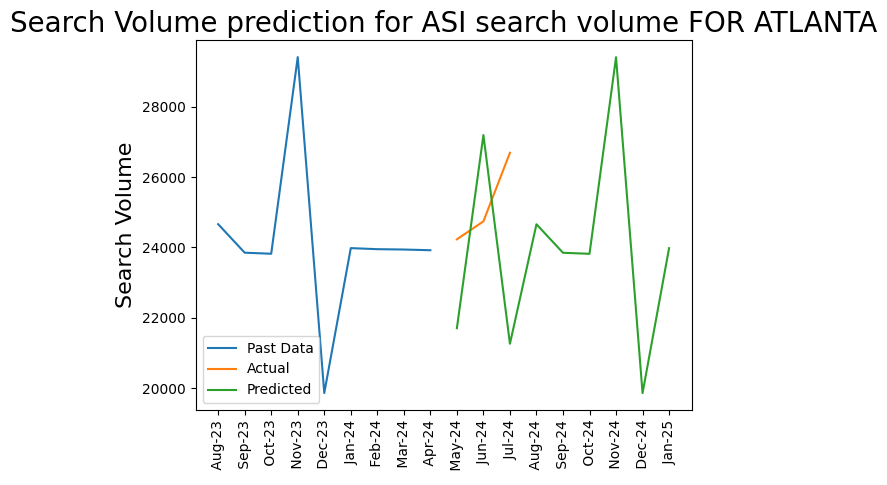

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


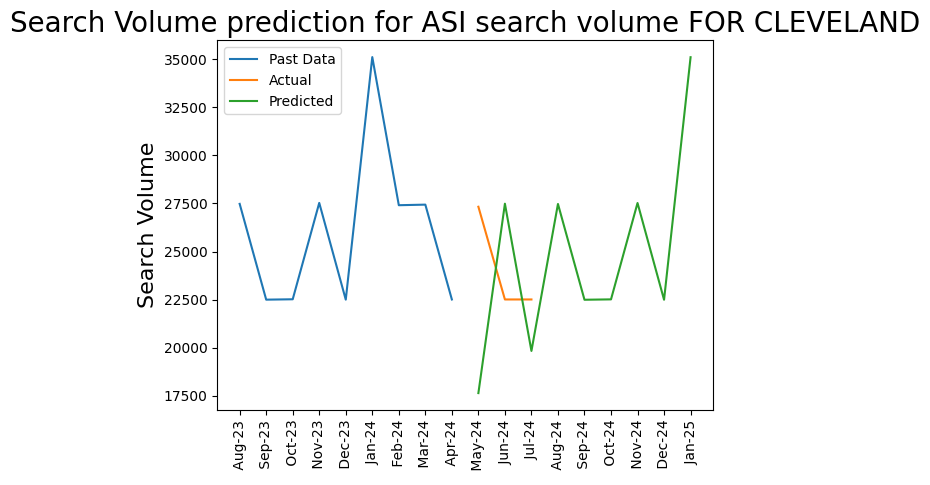

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


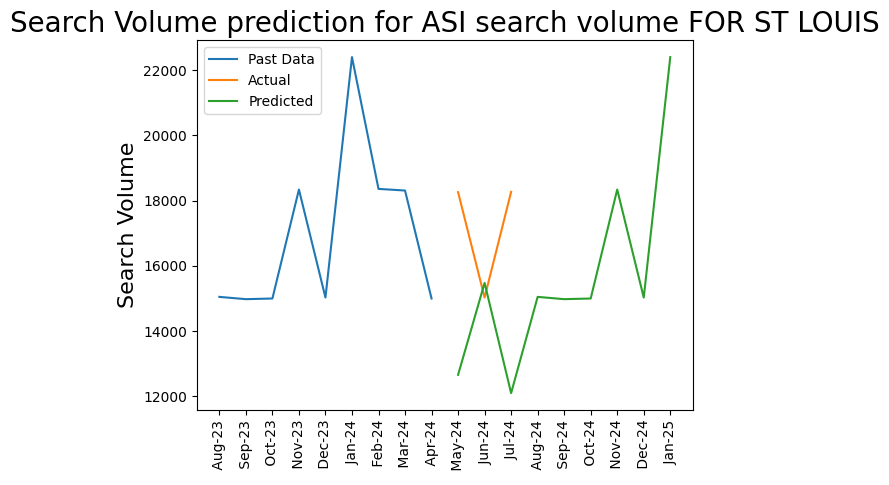

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


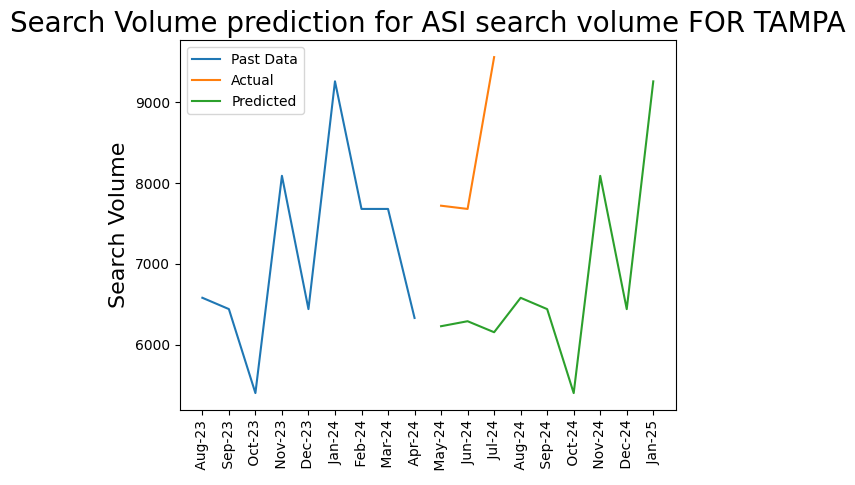

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


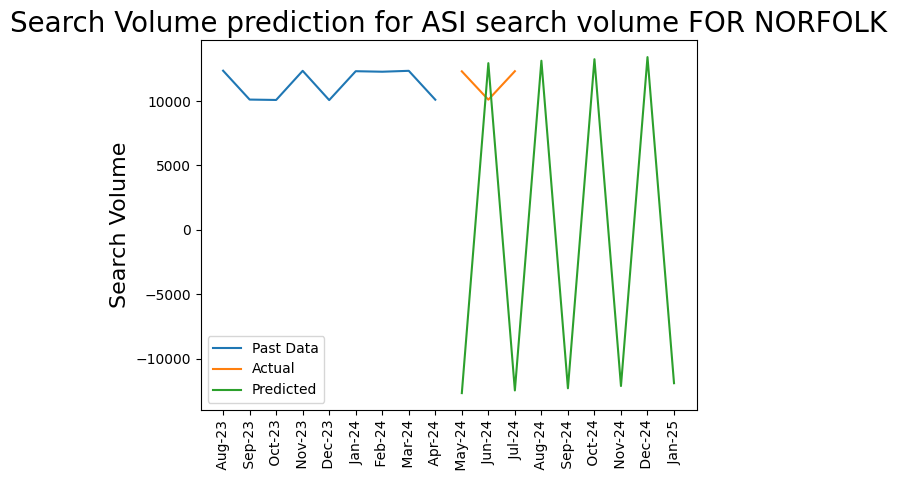

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


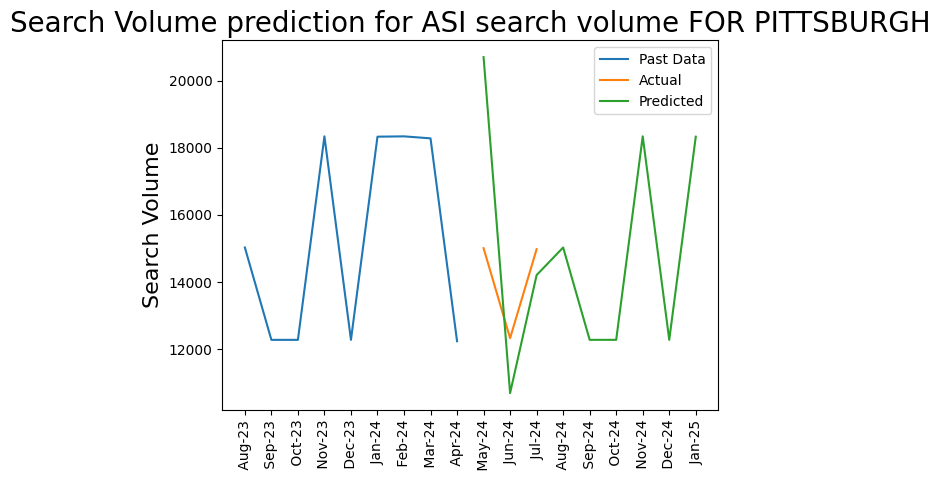

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


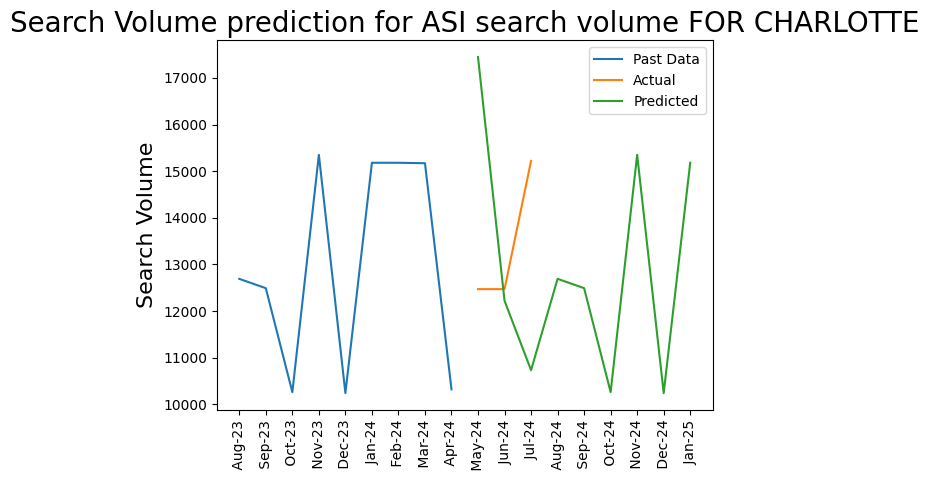

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


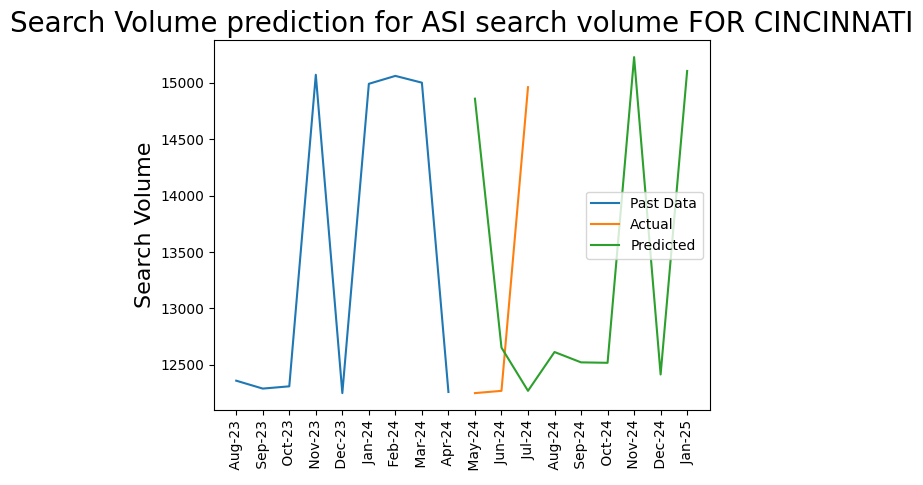

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


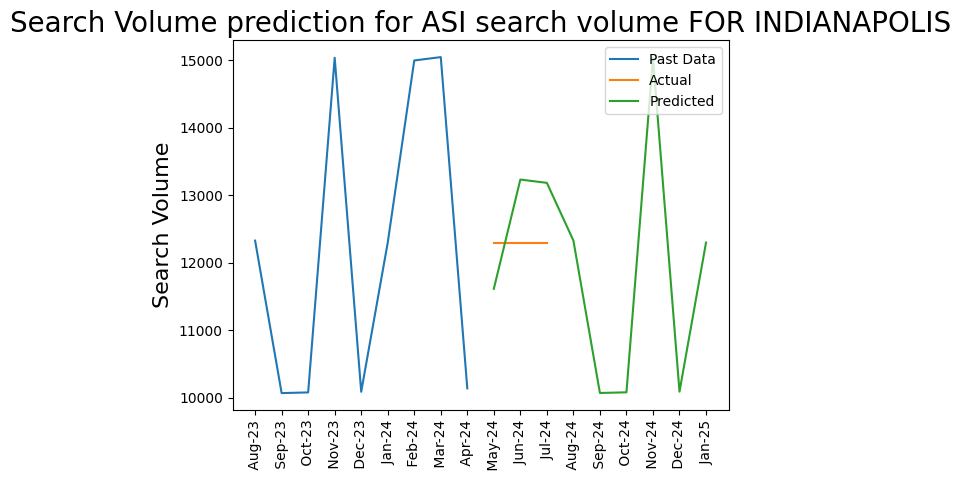

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


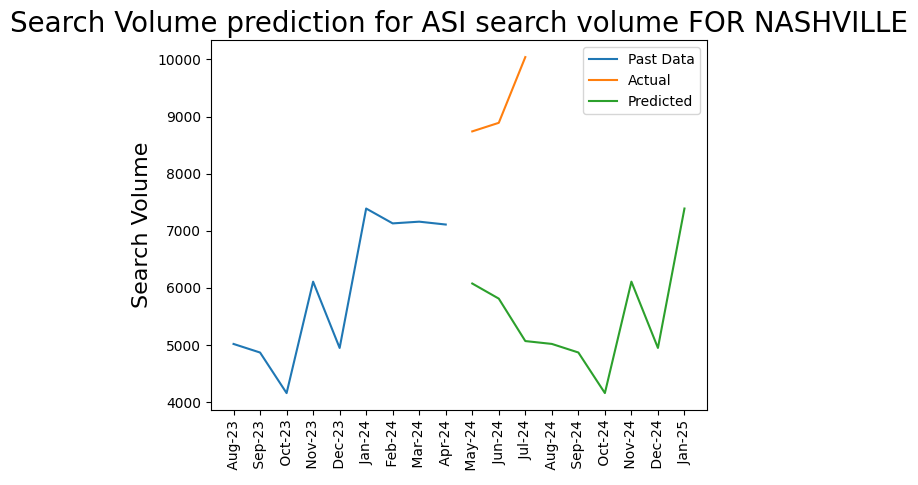

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


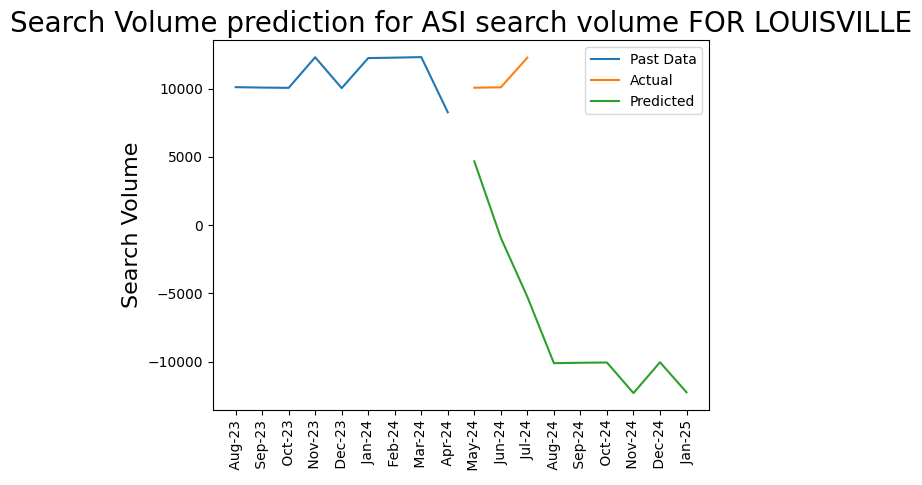

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


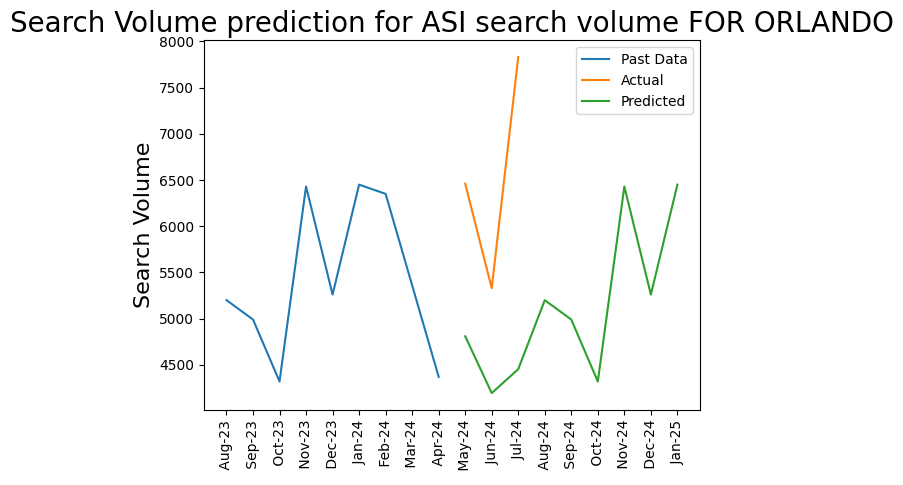

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


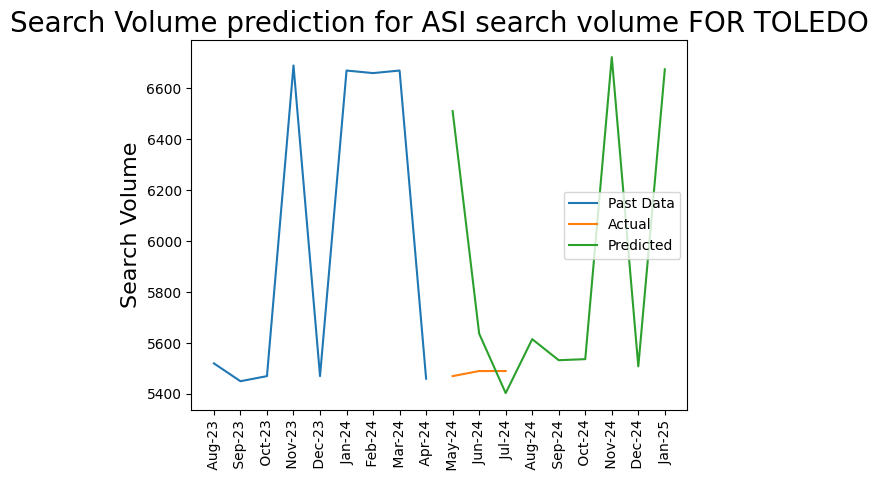

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


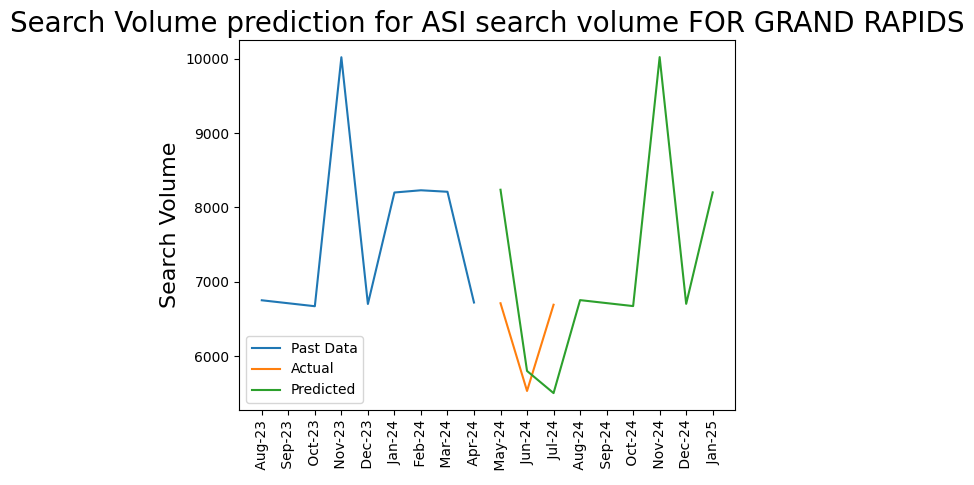

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


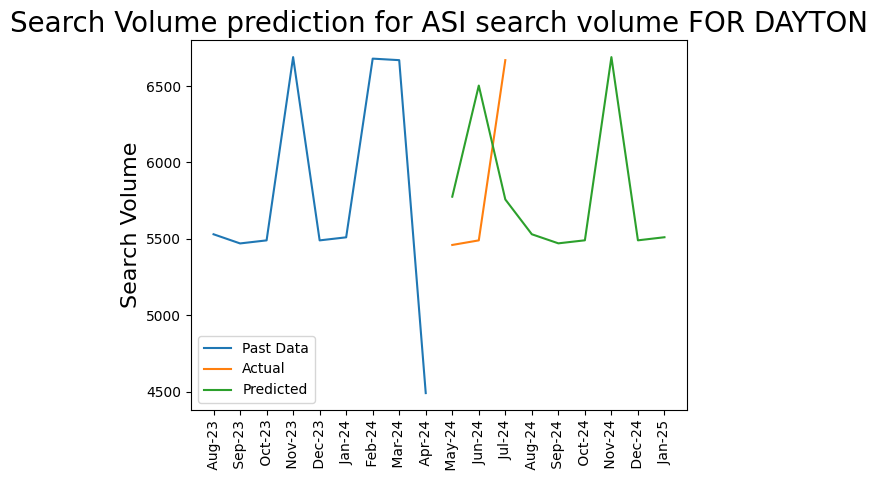

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


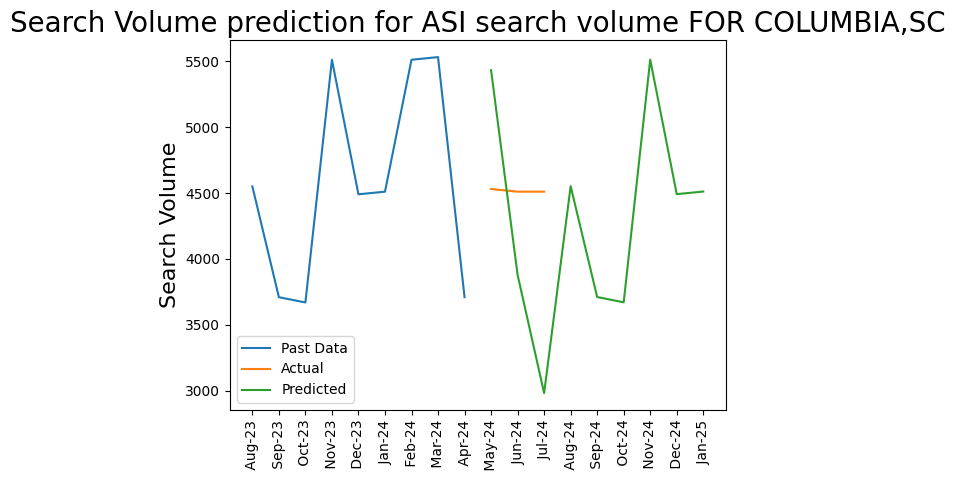

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


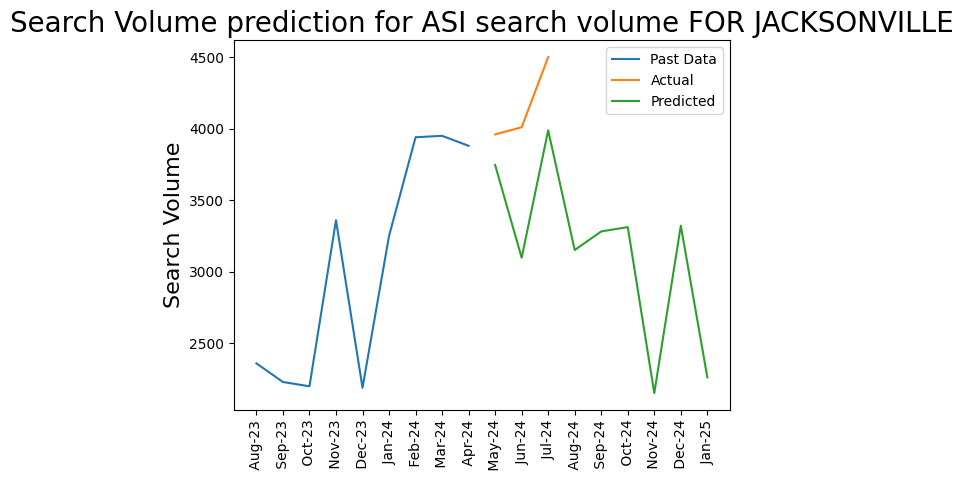

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


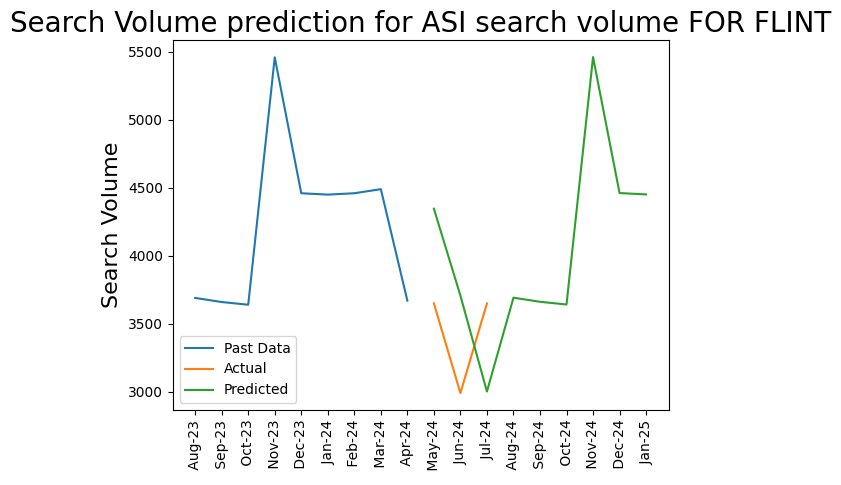

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


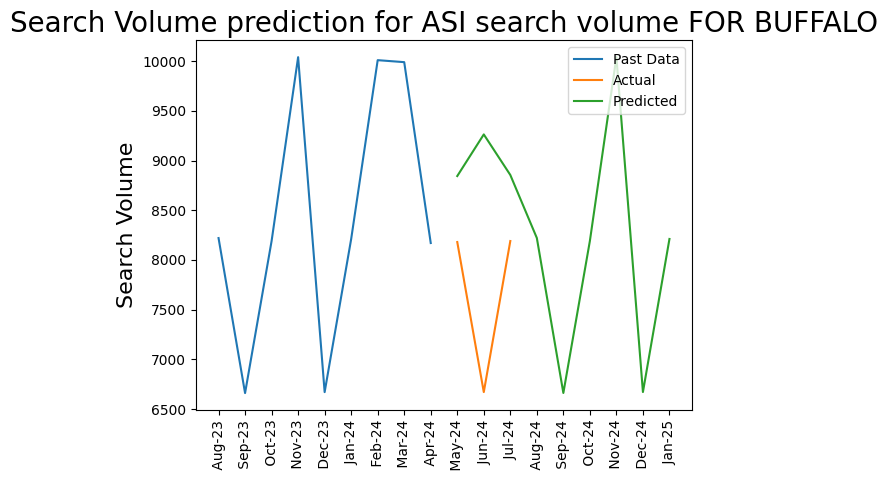

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


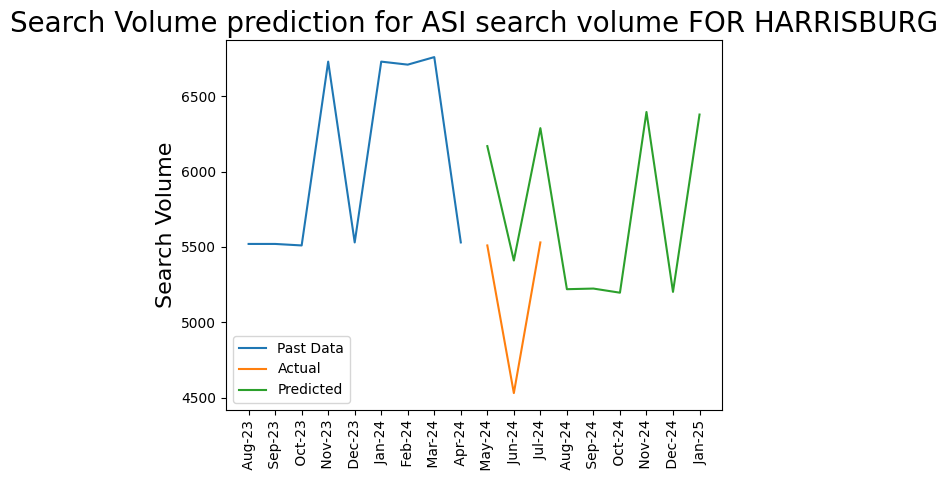

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


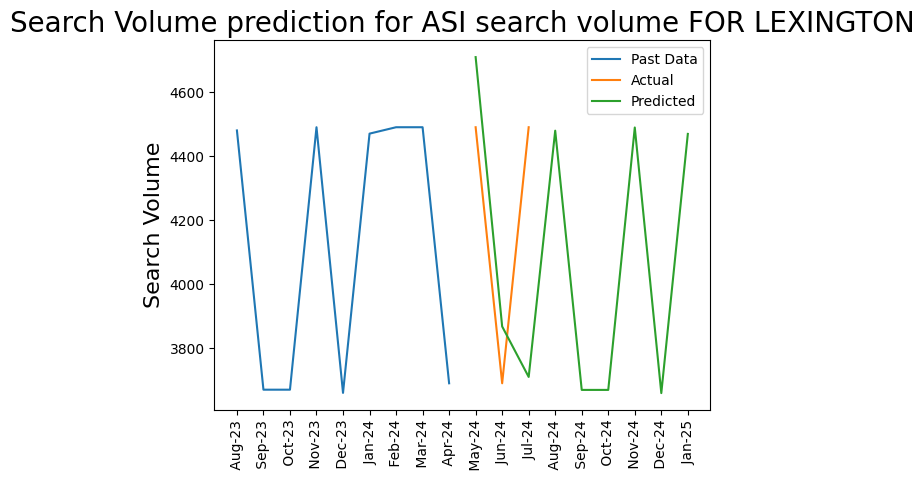

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


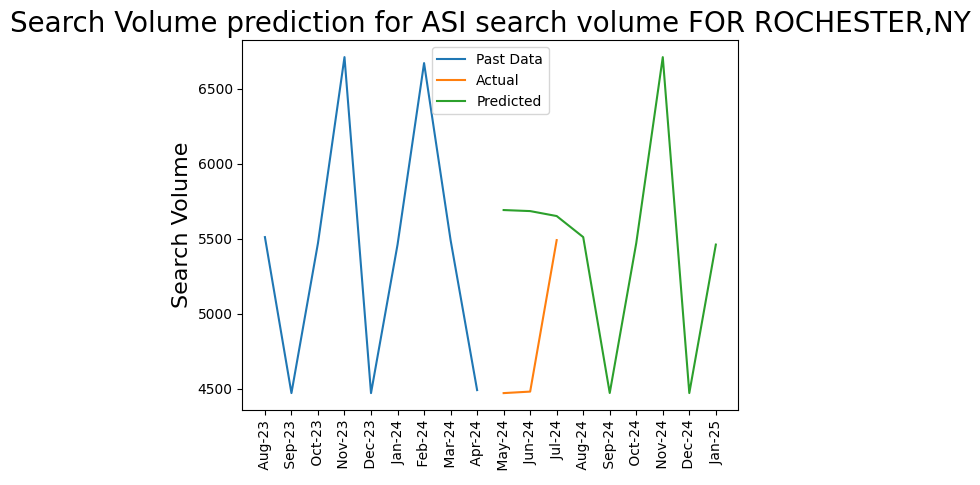

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


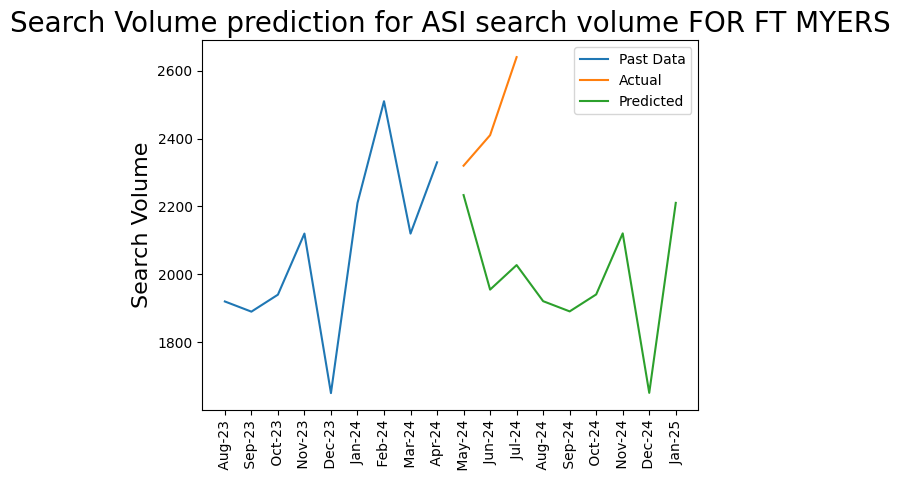

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


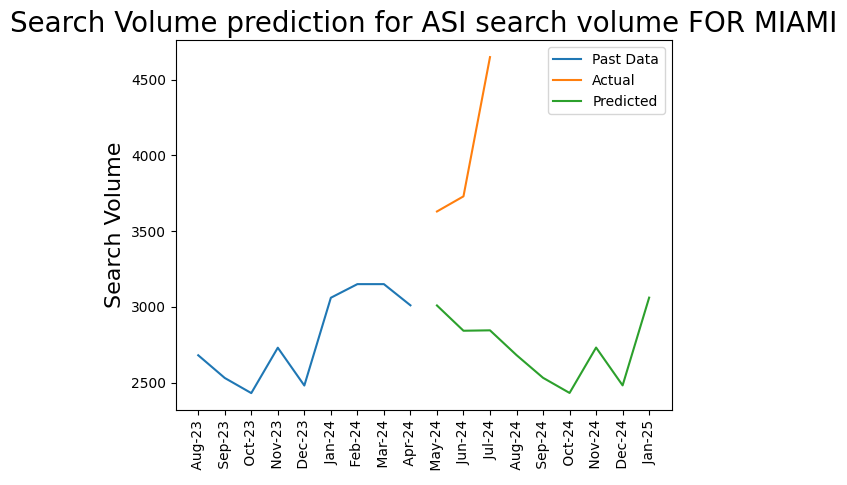

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


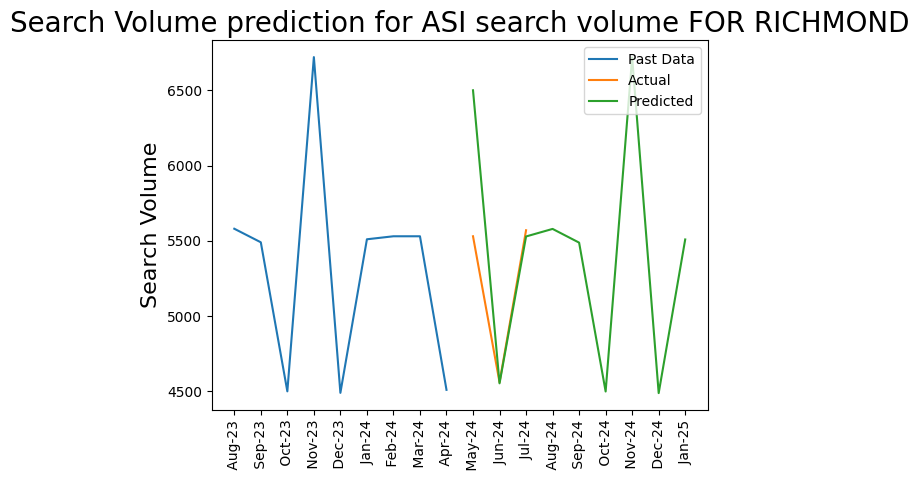

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


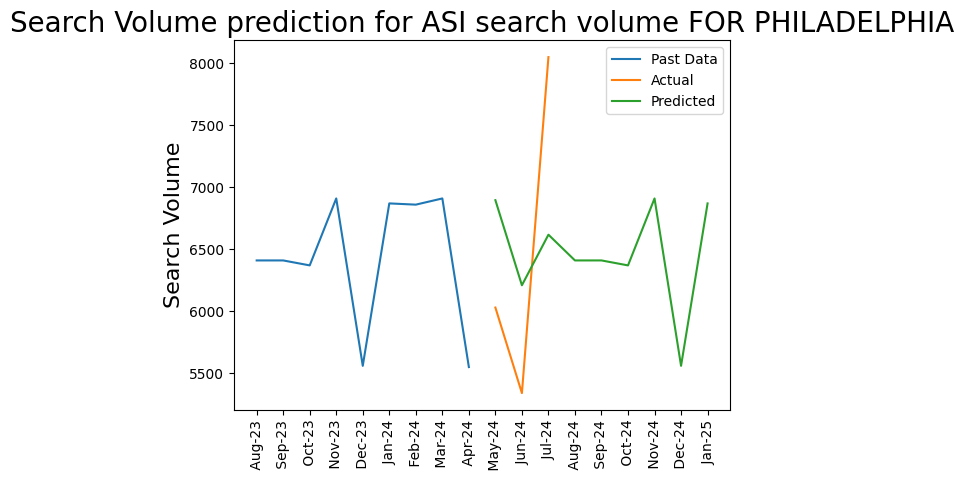

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


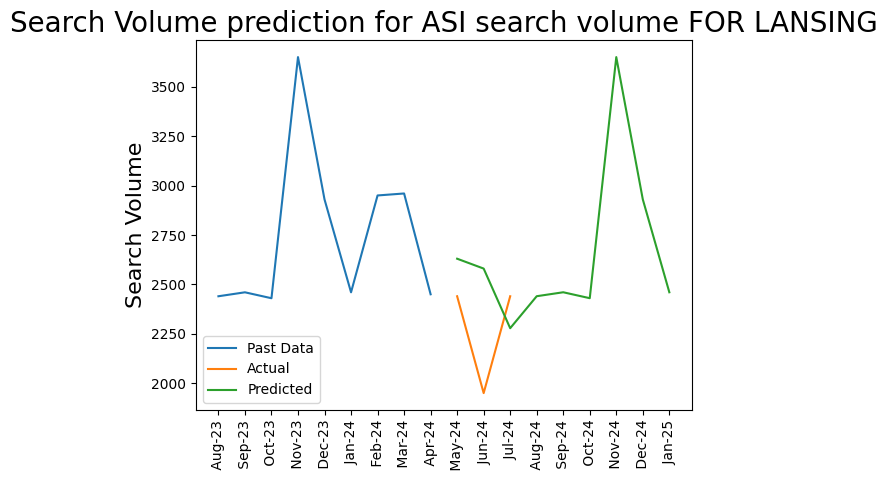

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


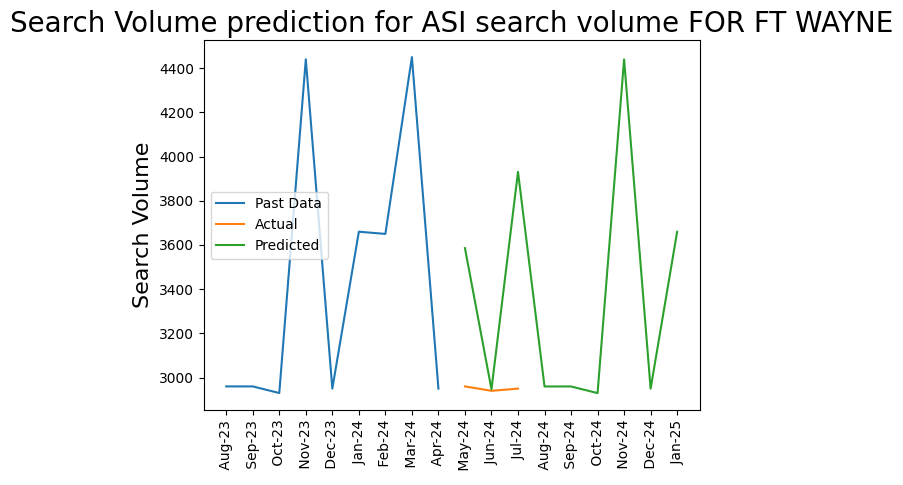

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


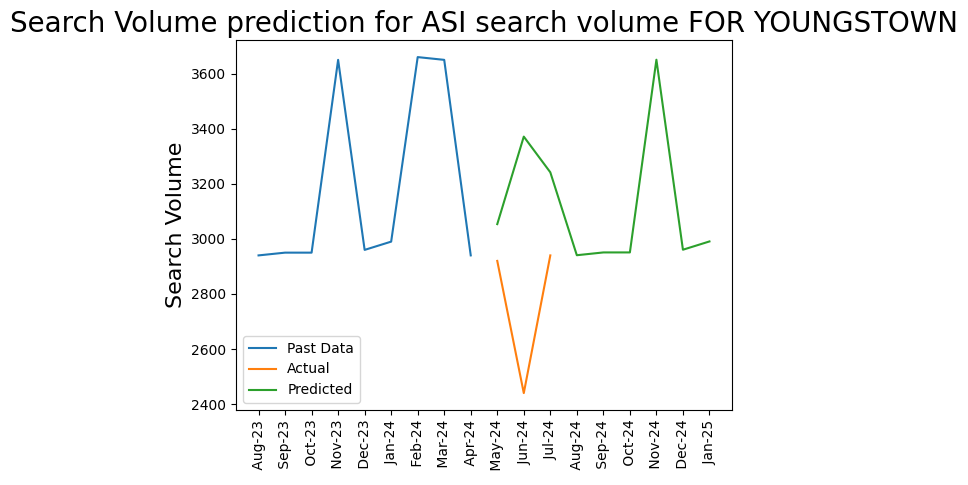

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


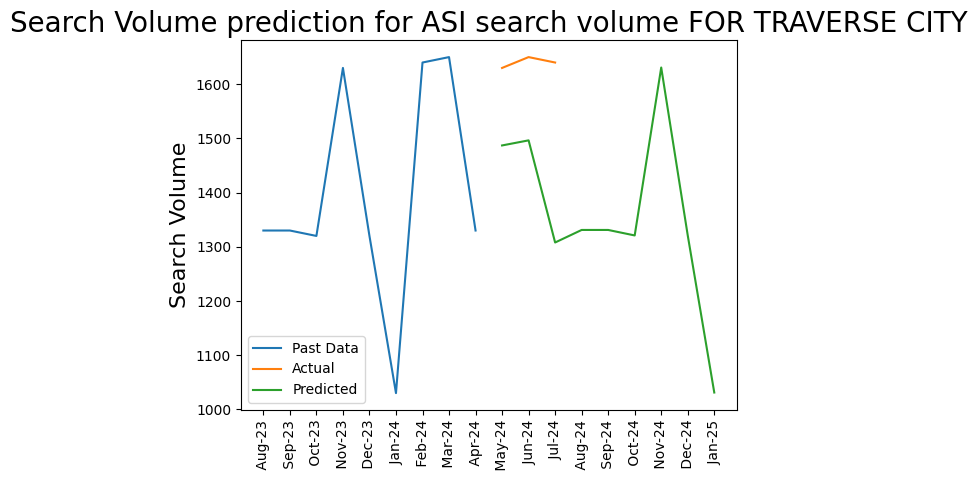

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


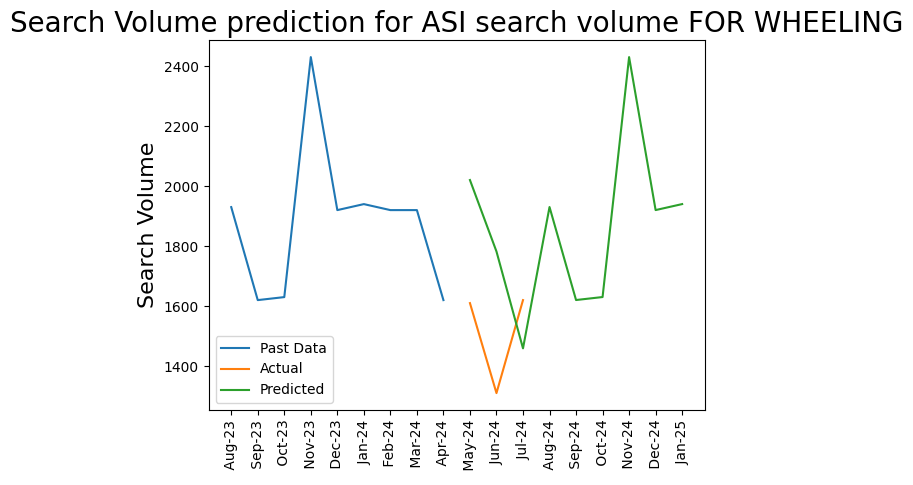

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


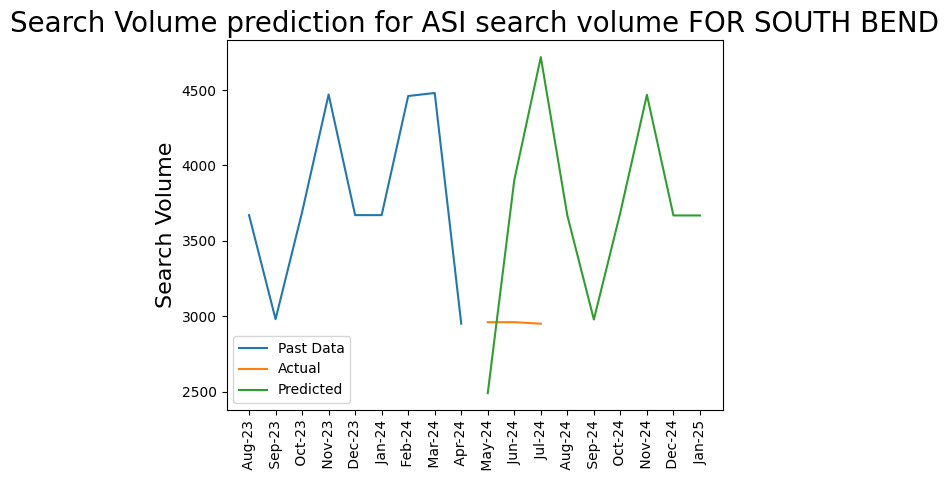

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


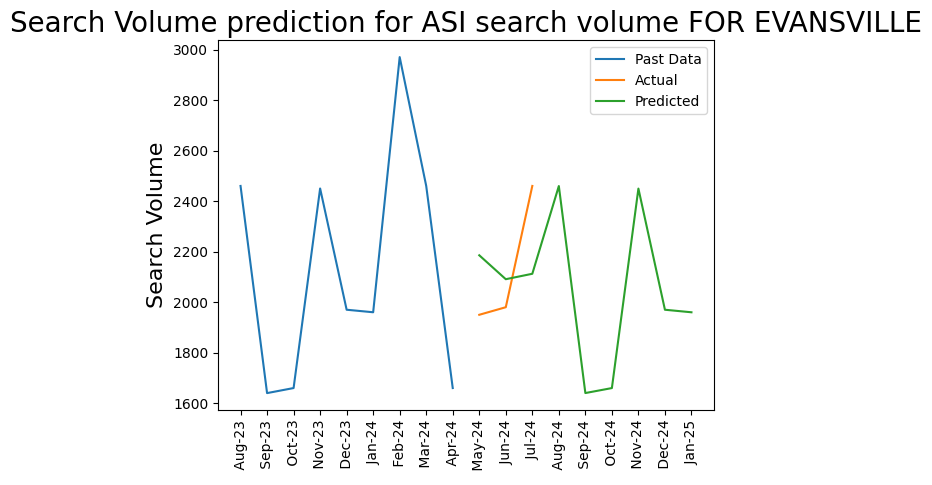

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


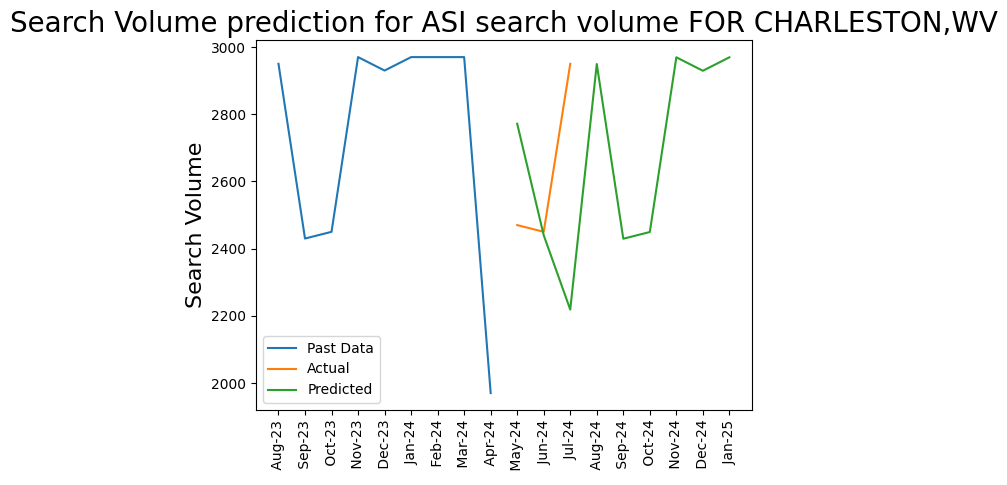

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


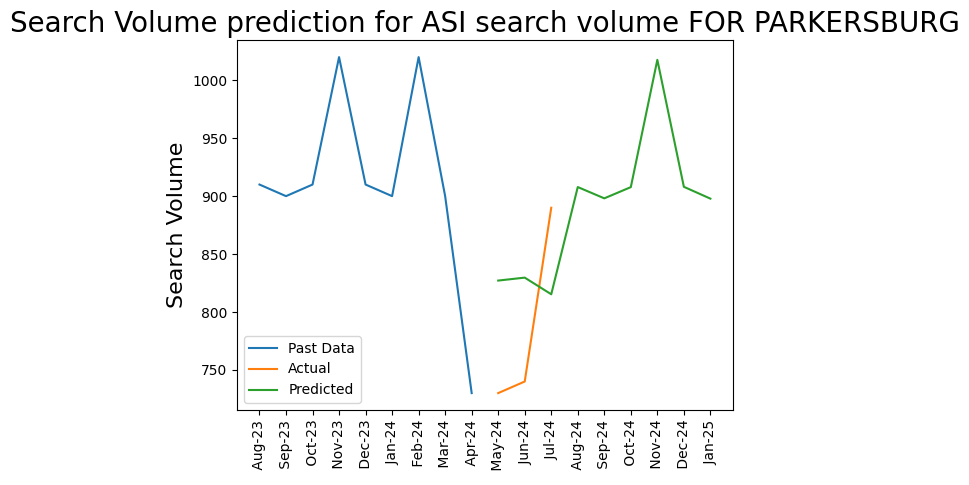

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


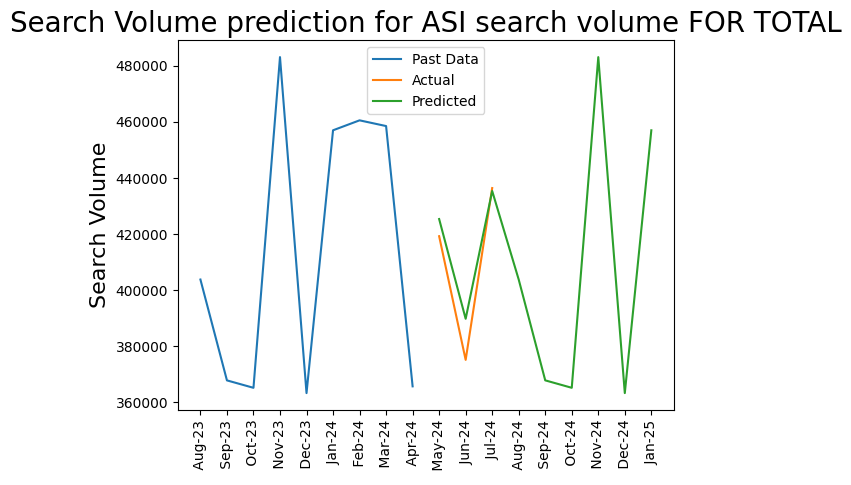

In [13]:
prediction_times = [" May-24"," Jun-24"," Jul-24"," Aug-24"," Sep-24"," Oct-24"," Nov-24"," Dec-24", " Jan-25"]

for x in df.columns:
  sarima = SARIMAX(y_train[x].to_numpy(),
                   order=(3, 0, 2),
                   seasonal_order = (2,0,2,12), # 12 beacause each season is around a year
                   ).fit()
  predictions = sarima.forecast(steps = 9)
  predictions = pd.Series(predictions, index=prediction_times)

  plt.plot(y_train[x], label = "Past Data")
  plt.plot(y_test[x], label="Actual")
  plt.plot(predictions, label="Predicted")
  plt.title('Search Volume prediction for ASI search volume FOR ' + str(x), fontsize=20)
  plt.ylabel('Search Volume', fontsize=16)
  plt.xticks(rotation = 90)
  plt.legend()
  plt.show()

## Trying DMA prediction using SoS

In [14]:
# Use the link you provided to open the Google Sheet
spreadsheet_url = 'https://docs.google.com/spreadsheets/d/129KmBvw1VU5LckE5vZ5Ggd0i6L4bbQvKbjKbmEwzWYs/edit?gid=0#gid=0'

# Open the spreadsheet
spreadsheet = gc.open_by_url(spreadsheet_url)

# Select the first worksheet
worksheet = spreadsheet.sheet1

# Get all the data and convert it to a pandas DataFrame
SoS_data = worksheet.get_all_records()
SoS_df = pd.DataFrame(SoS_data)

# Display the first few rows of the DataFrame
SoS_df.head()

DMA / Location  CHICAGO  DETROIT  WASHINGTON,DC  COLUMBUS,OH  BALTIMORE  \
0         Aug-23    0.057    0.087          0.060        0.145      0.091   
1         Sep-23    0.062    0.096          0.053        0.131      0.081   
2         Oct-23    0.059    0.088          0.052        0.124      0.074   
3         Nov-23    0.058    0.081          0.060        0.142      0.087   
4         Dec-23    0.056    0.077          0.049        0.116      0.069   

   ATLANTA  CLEVELAND  ST LOUIS  TAMPA  ...  PHILADELPHIA  LANSING  FT WAYNE  \
0    0.044      0.101     0.075  0.016  ...         0.012    0.083     0.091   
1    0.047      0.090     0.080  0.016  ...         0.013    0.085     0.095   
2    0.047      0.085     0.080  0.013  ...         0.012    0.084     0.093   
3    0.046      0.083     0.075  0.016  ...         0.011    0.096     0.108   
4    0.037      0.077     0.076  0.015  ...         0.010    0.084     0.084   

   YOUNGSTOWN  TRAVERSE CITY  WHEELING  SOUTH BEND  EVANSVILLE  CHARLESTON,WV  \
0       0.101          0.056     0.150       0.098       0.091          0.065   
1       0.109          0.059     0.129       0.087       0.069          0.057   
2       0.099          0.057     0.117       0.101       0.066          0.053   
3       0.097          0.059     0.128       0.102       0.078          0.052   
4       0.093          0.060     0.124       0.094       0.070          0.055   

   PARKERSBURG  
0        0.134  
1        0.134  
2        0.120  
3        0.104  
4        0.111  

[5 rows x 41 columns]

In [15]:
print(SoS_df.shape)
print(SoS_df.columns)
SoS_df.set_index('DMA / Location', inplace=True)
SoS_df

(12, 41)
Index(['DMA / Location', 'CHICAGO', 'DETROIT', 'WASHINGTON,DC', 'COLUMBUS,OH',
       'BALTIMORE', 'ATLANTA', 'CLEVELAND', 'ST LOUIS', 'TAMPA', 'NORFOLK',
       'PITTSBURGH', 'CHARLOTTE', 'CINCINNATI', 'INDIANAPOLIS', 'NASHVILLE',
       'LOUISVILLE', 'ORLANDO', 'TOLEDO', 'GRAND RAPIDS', 'DAYTON',
       'COLUMBIA,SC', 'JACKSONVILLE', 'FLINT', 'BUFFALO', 'HARRISBURG',
       'LEXINGTON', 'ROCHESTER,NY', 'FT MYERS', 'MIAMI', 'RICHMOND',
       'PHILADELPHIA', 'LANSING', 'FT WAYNE', 'YOUNGSTOWN', 'TRAVERSE CITY',
       'WHEELING', 'SOUTH BEND', 'EVANSVILLE', 'CHARLESTON,WV', 'PARKERSBURG'],
      dtype='object')


CHICAGO  DETROIT  WASHINGTON,DC  COLUMBUS,OH  BALTIMORE  \
DMA / Location                                                            
Aug-23            0.057    0.087          0.060        0.145      0.091   
Sep-23            0.062    0.096          0.053        0.131      0.081   
Oct-23            0.059    0.088          0.052        0.124      0.074   
Nov-23            0.058    0.081          0.060        0.142      0.087   
Dec-23            0.056    0.077          0.049        0.116      0.069   
Jan-24            0.064    0.104          0.061        0.128      0.087   
Feb-24            0.070    0.099          0.060        0.137      0.100   
Mar-24            0.069    0.098          0.065        0.147      0.108   
Apr-24            0.063    0.090          0.059        0.132      0.082   
May-24            0.068    0.091          0.060        0.140      0.091   
Jun-24            0.058    0.091          0.055        0.117      0.080   
Jul-24            0.067    0.087          0.059        0.131      0.091   

                ATLANTA  CLEVELAND  ST LOUIS  TAMPA  NORFOLK  ...  \
DMA / Location                                                ...   
Aug-23            0.044      0.101     0.075  0.016    0.101  ...   
Sep-23            0.047      0.090     0.080  0.016    0.095  ...   
Oct-23            0.047      0.085     0.080  0.013    0.097  ...   
Nov-23            0.046      0.083     0.075  0.016    0.091  ...   
Dec-23            0.037      0.077     0.076  0.015    0.092  ...   
Jan-24            0.041      0.110     0.099  0.019    0.096  ...   
Feb-24            0.047      0.090     0.084  0.018    0.095  ...   
Mar-24            0.045      0.094     0.088  0.019    0.100  ...   
Apr-24            0.050      0.085     0.084  0.016    0.093  ...   
May-24            0.044      0.102     0.088  0.019    0.096  ...   
Jun-24            0.047      0.083     0.076  0.019    0.082  ...   
Jul-24            0.045      0.077     0.090  0.022    0.087  ...   

                PHILADELPHIA  LANSING  FT WAYNE  YOUNGSTOWN  TRAVERSE CITY  \
DMA / Location                                                               
Aug-23                 0.012    0.083     0.091       0.101          0.056   
Sep-23                 0.013    0.085     0.095       0.109          0.059   
Oct-23                 0.012    0.084     0.093       0.099          0.057   
Nov-23                 0.011    0.096     0.108       0.097          0.059   
Dec-23                 0.010    0.084     0.084       0.093          0.060   
Jan-24                 0.012    0.076     0.096       0.085          0.046   
Feb-24                 0.012    0.091     0.102       0.106          0.068   
Mar-24                 0.013    0.090     0.126       0.113          0.069   
Apr-24                 0.012    0.075     0.092       0.099          0.059   
May-24                 0.012    0.078     0.095       0.093          0.061   
Jun-24                 0.011    0.065     0.091       0.082          0.062   
Jul-24                 0.015    0.076     0.086       0.085          0.055   

                WHEELING  SOUTH BEND  EVANSVILLE  CHARLESTON,WV  PARKERSBURG  
DMA / Location                                                                
Aug-23             0.150       0.098       0.091          0.065        0.134  
Sep-23             0.129       0.087       0.069          0.057        0.134  
Oct-23             0.117       0.101       0.066          0.053        0.120  
Nov-23             0.128       0.102       0.078          0.052        0.104  
Dec-23             0.124       0.094       0.070          0.055        0.111  
Jan-24             0.116       0.094       0.059          0.054        0.106  
Feb-24             0.122       0.110       0.091          0.054        0.116  
Mar-24             0.127       0.113       0.079          0.061        0.105  
Apr-24             0.123       0.085       0.066          0.048        0.104  
May-24             0.118       0.083

In [16]:
#need to split the data into train and test
# test set is last 3 months
train_rows=SoS_df.iloc[:-3]
test_rows=SoS_df.iloc[-3:]


import datetime

# we need to do this because this will convert it to a date time object
# then we convert this to a dataframe
X_train=[datetime.datetime.strptime(x.strip(), '%b-%y') for x in train_rows.index]

# y_train= train_rows.to_numpy()
X_train_df= pd.DataFrame(X_train)
y_train=train_rows.apply(pd.to_numeric, errors = 'coerce')




X_test = [datetime.datetime.strptime(x.strip(), '%b-%y') for x in test_rows.index]
# y_test = test_rows.to_numpy()
X_test_df= pd.DataFrame(X_test)
y_test = test_rows.apply(pd.to_numeric, errors = 'coerce')


y_test


CHICAGO  DETROIT  WASHINGTON,DC  COLUMBUS,OH  BALTIMORE  \
DMA / Location                                                            
May-24            0.068    0.091          0.060        0.140      0.091   
Jun-24            0.058    0.091          0.055        0.117      0.080   
Jul-24            0.067    0.087          0.059        0.131      0.091   

                ATLANTA  CLEVELAND  ST LOUIS  TAMPA  NORFOLK  ...  \
DMA / Location                                                ...   
May-24            0.044      0.102     0.088  0.019    0.096  ...   
Jun-24            0.047      0.083     0.076  0.019    0.082  ...   
Jul-24            0.045      0.077     0.090  0.022    0.087  ...   

                PHILADELPHIA  LANSING  FT WAYNE  YOUNGSTOWN  TRAVERSE CITY  \
DMA / Location                                                               
May-24                 0.012    0.078     0.095       0.093          0.061   
Jun-24                 0.011    0.065     0.091       0.082          0.062   
Jul-24                 0.015    0.076     0.086       0.085          0.055   

                WHEELING  SOUTH BEND  EVANSVILLE  CHARLESTON,WV  PARKERSBURG  
DMA / Location                                                                
May-24             0.118       0.083       0.074          0.050        0.094  
Jun-24             0.097       0.079       0.067          0.050        0.093  
Jul-24             0.108       0.067       0.078          0.053        0.104  

[3 rows x 40 columns]

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


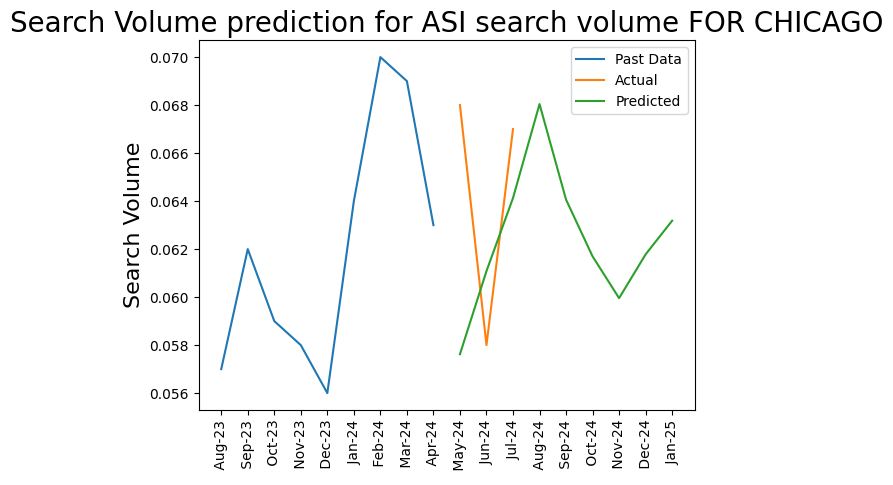

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


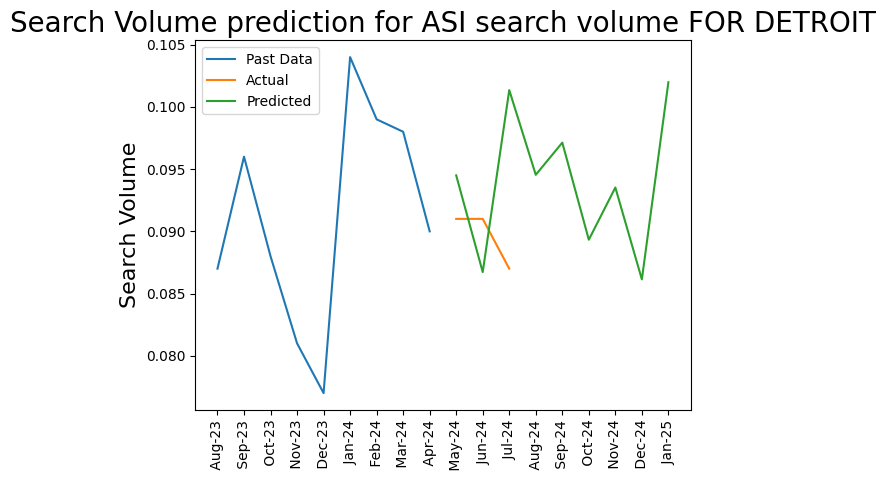

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


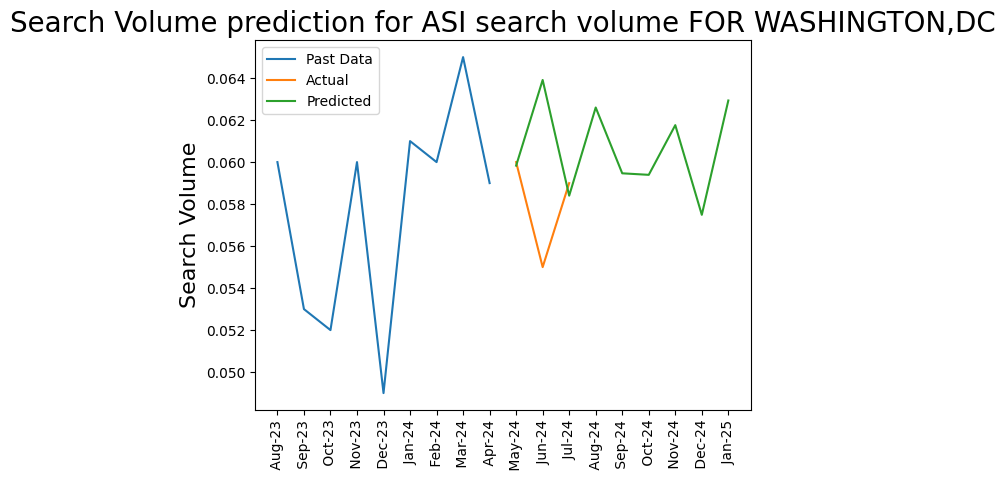

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


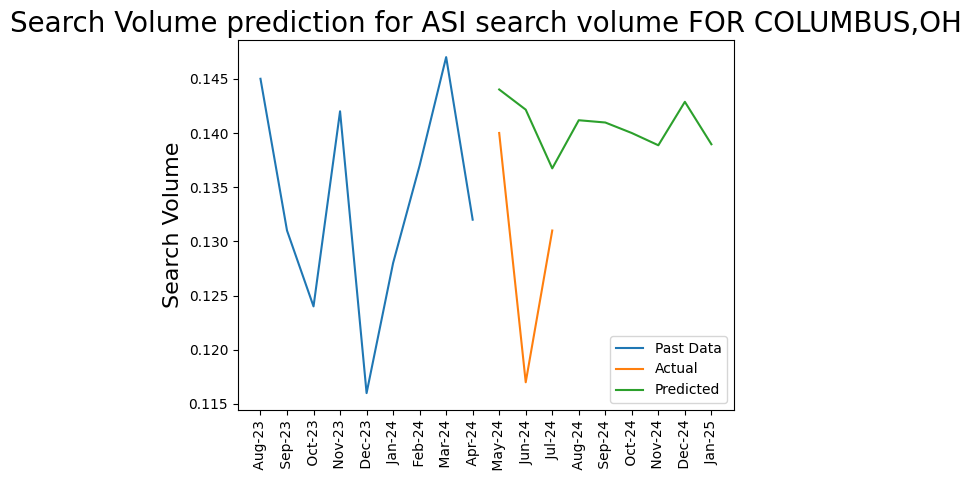

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


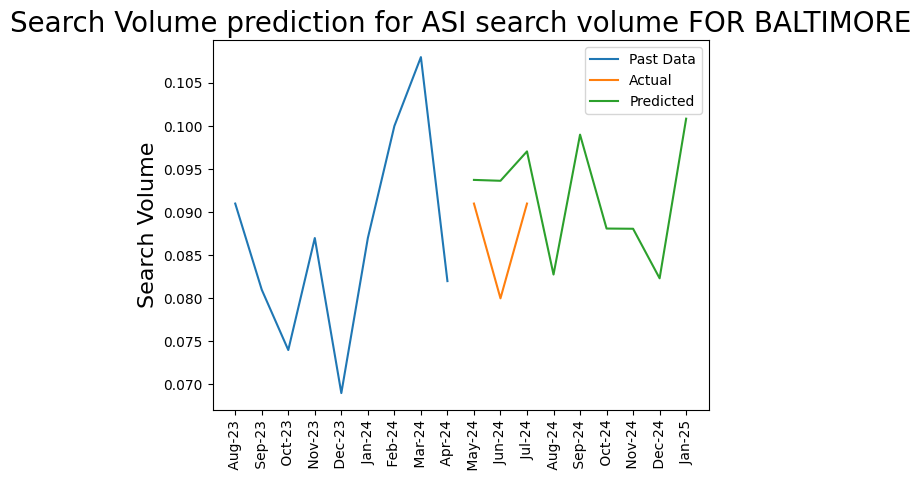

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


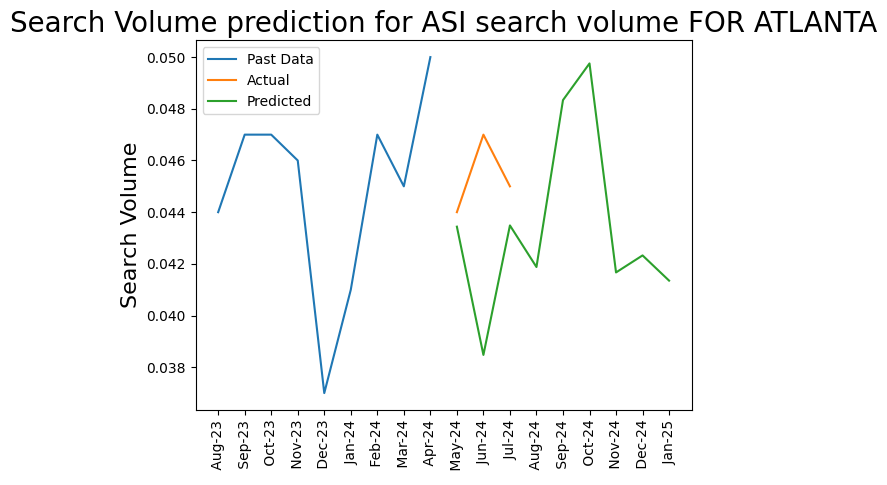

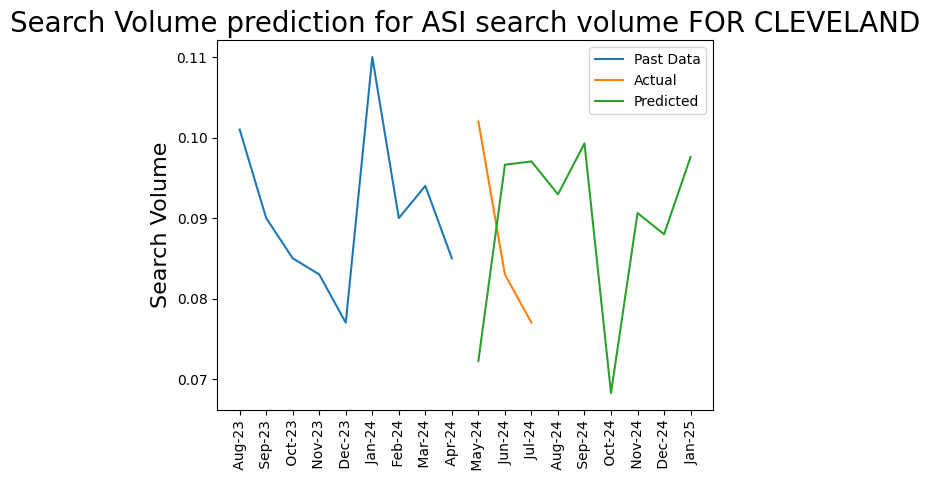

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


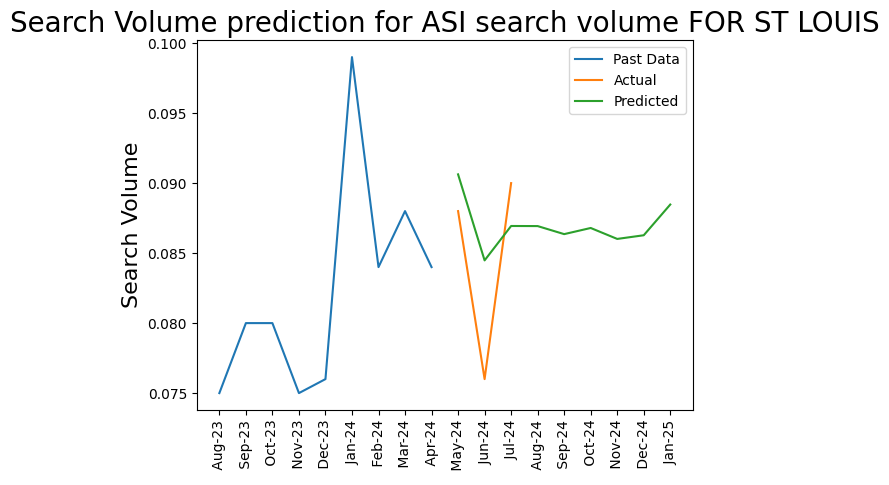

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


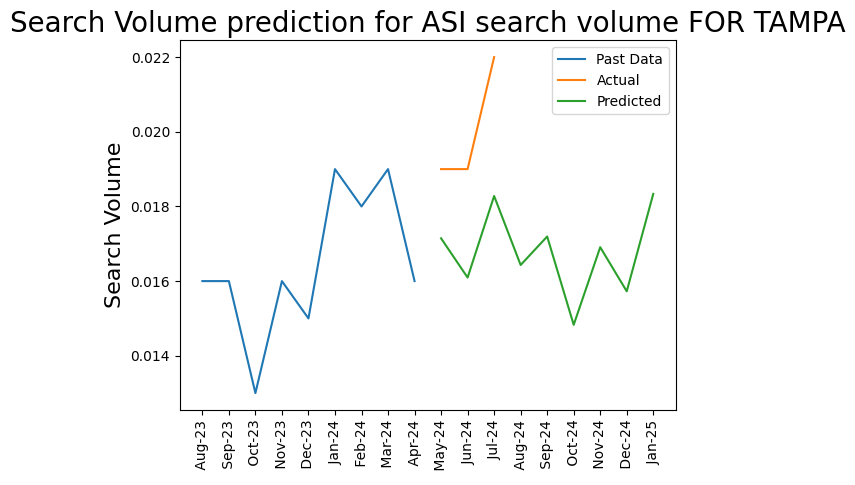

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


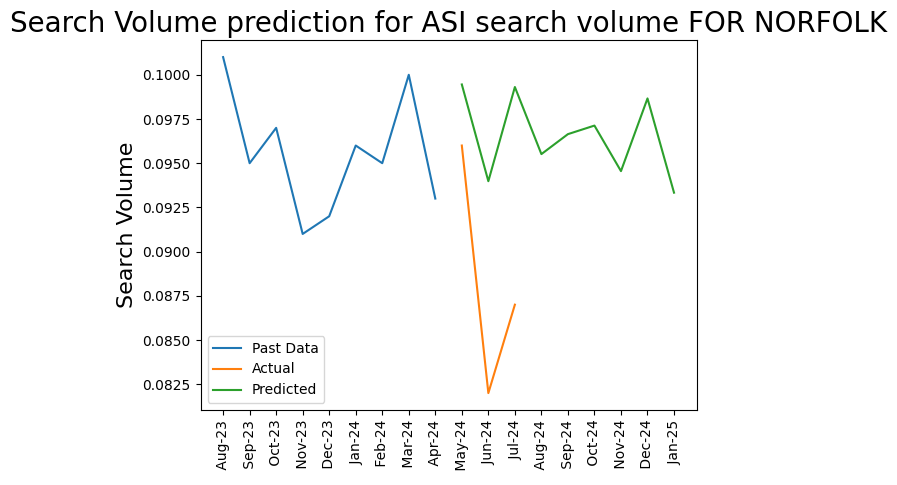

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


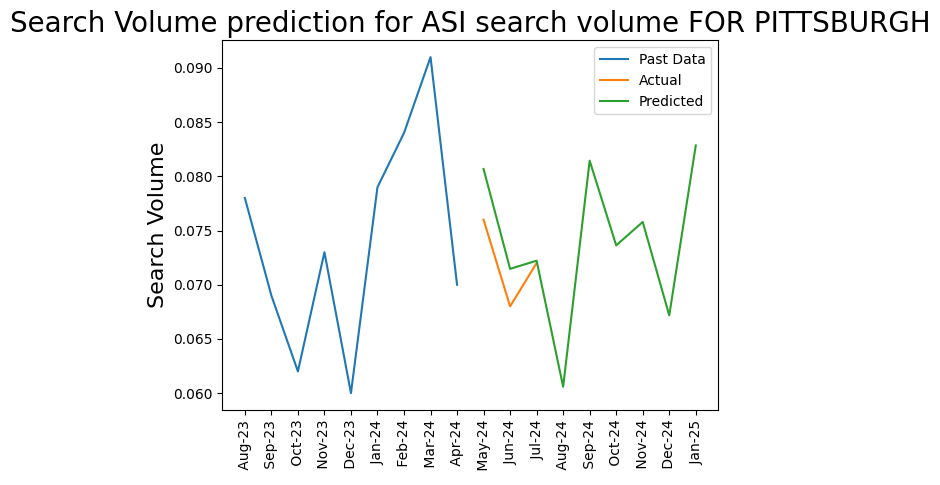

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


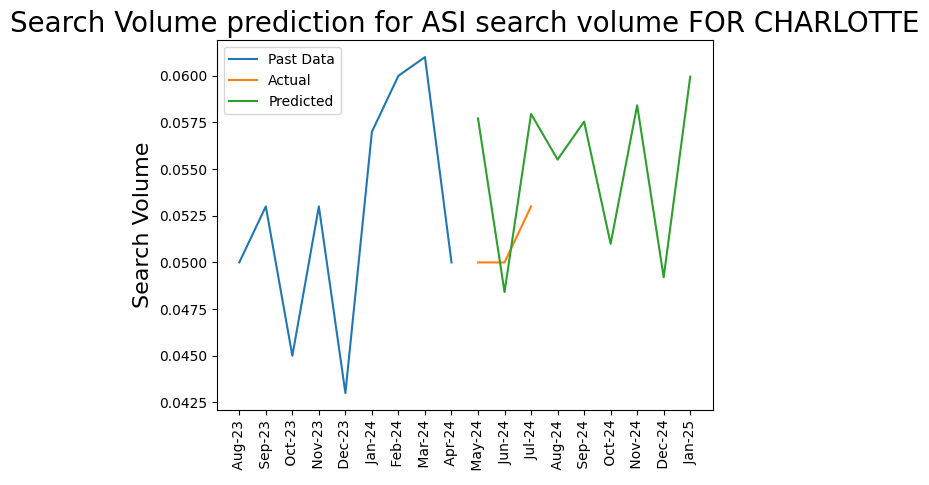

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


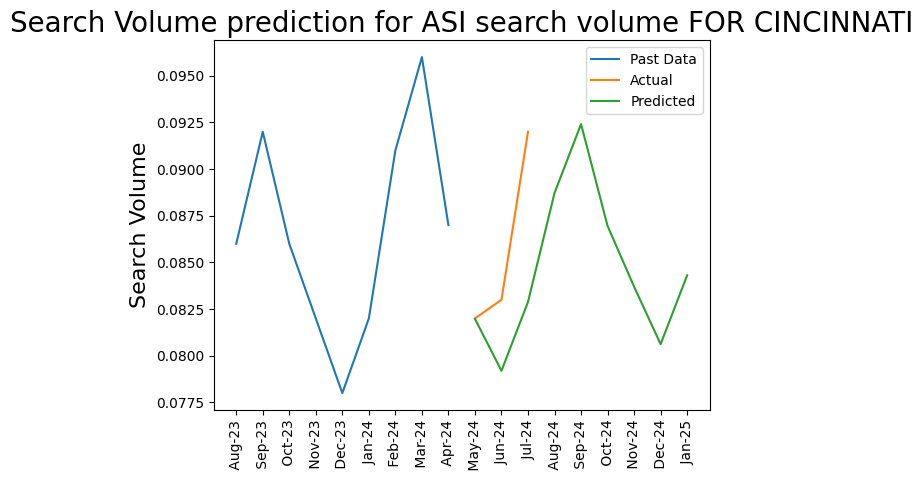

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


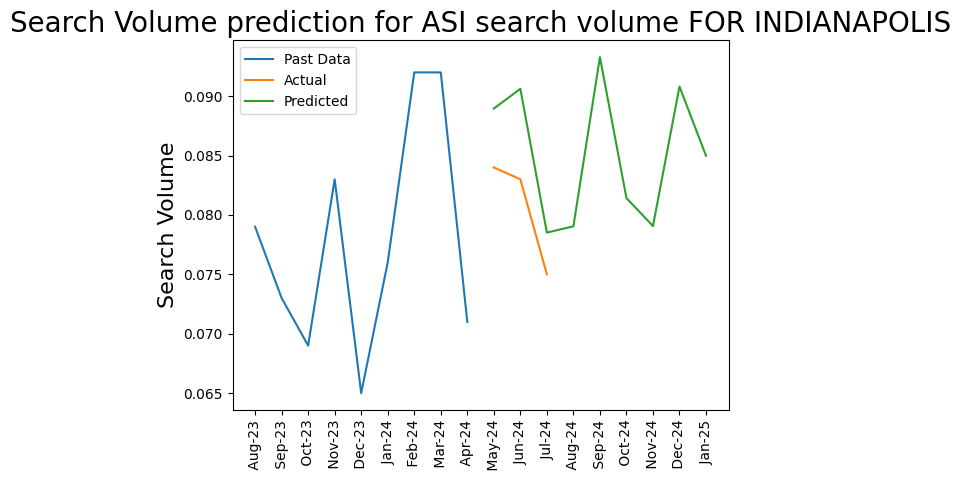

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


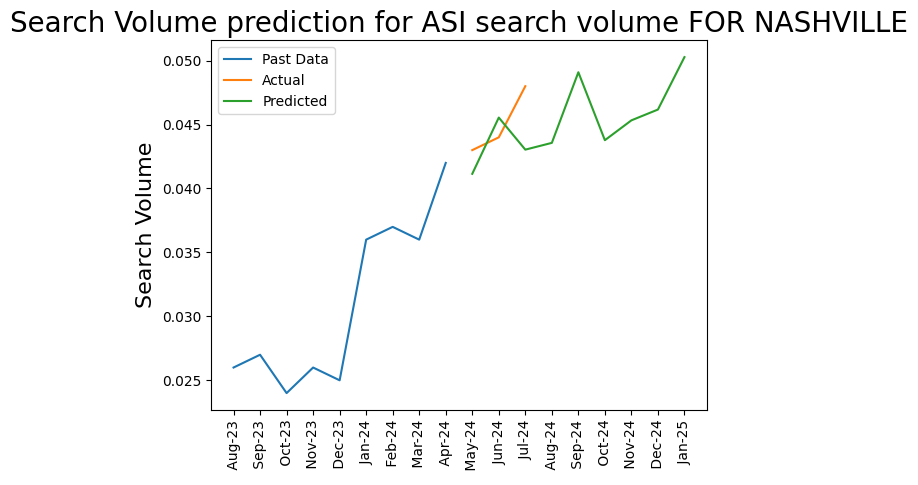

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


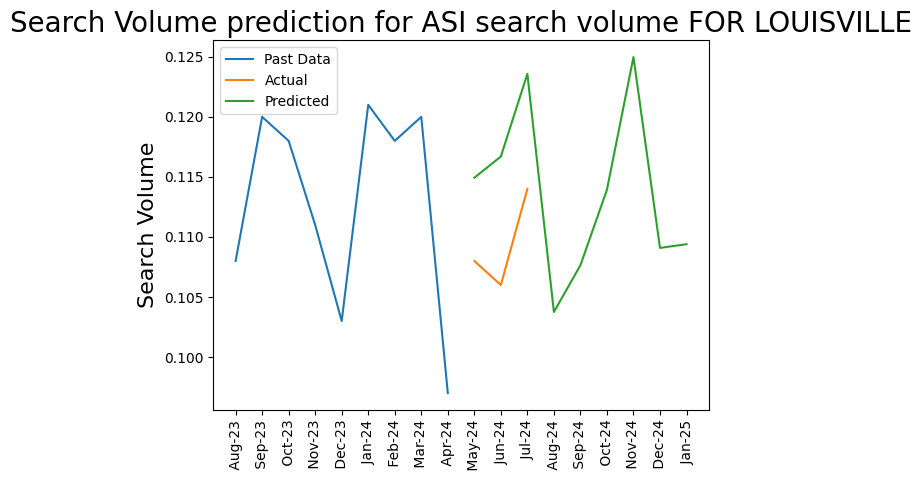

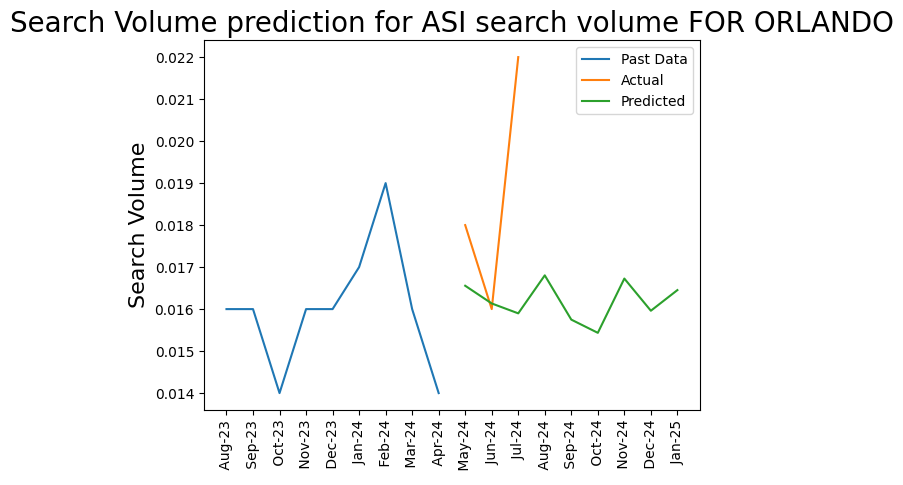

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


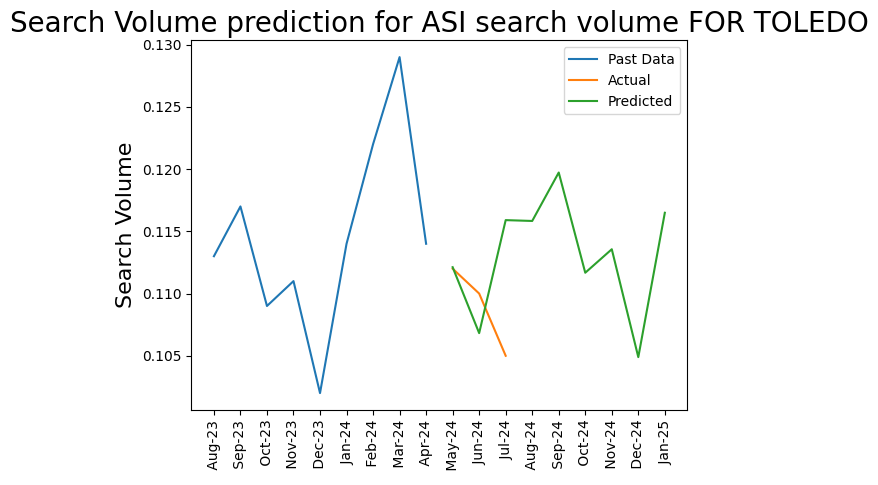

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


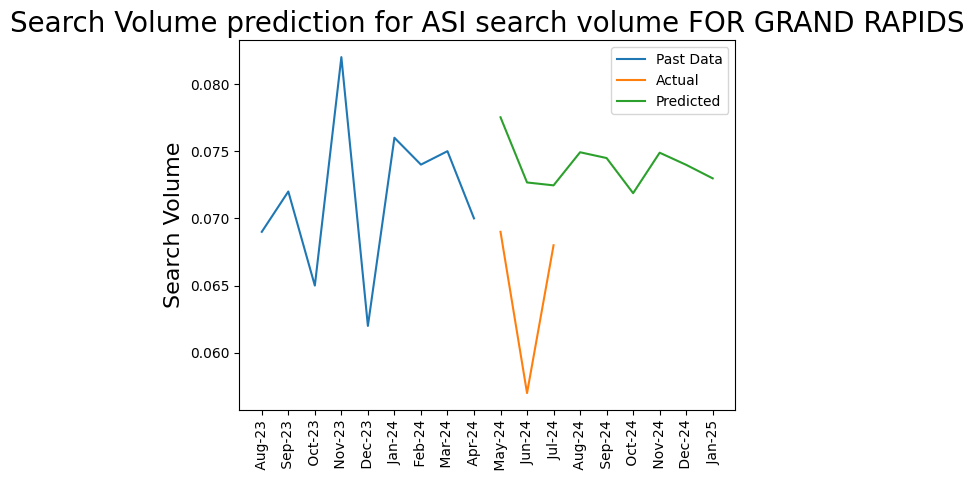

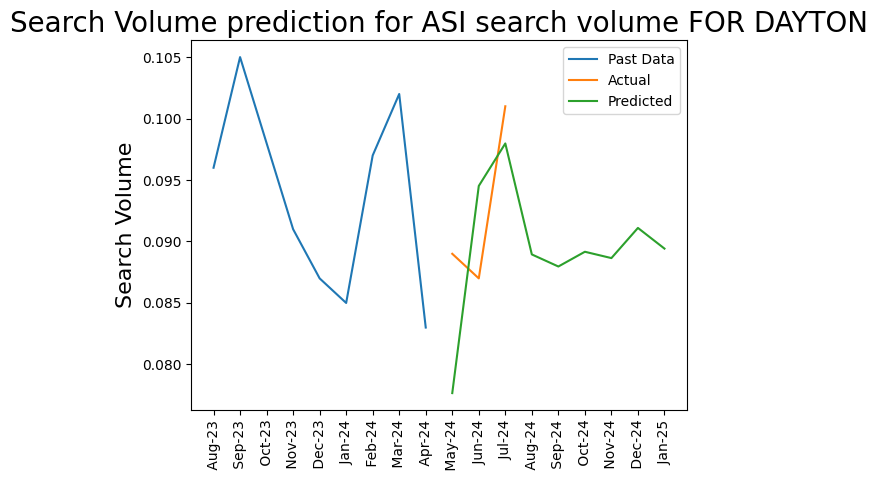

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


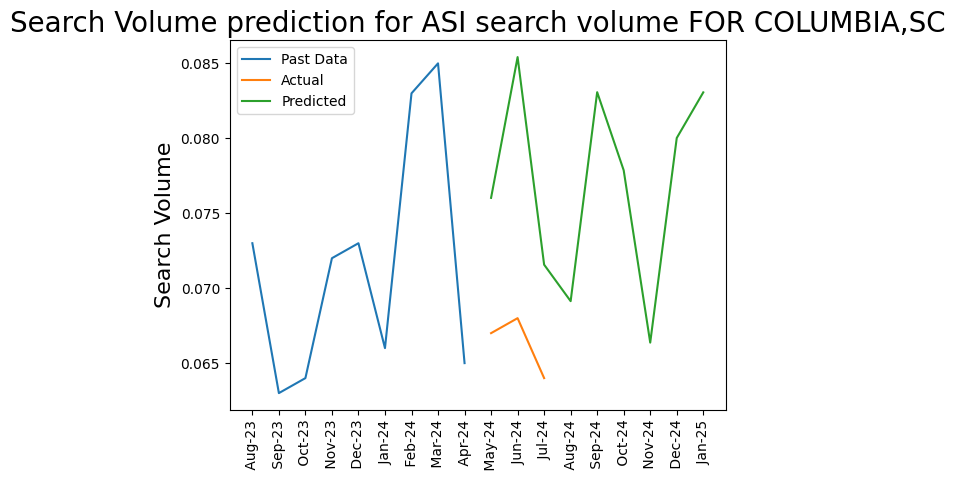

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


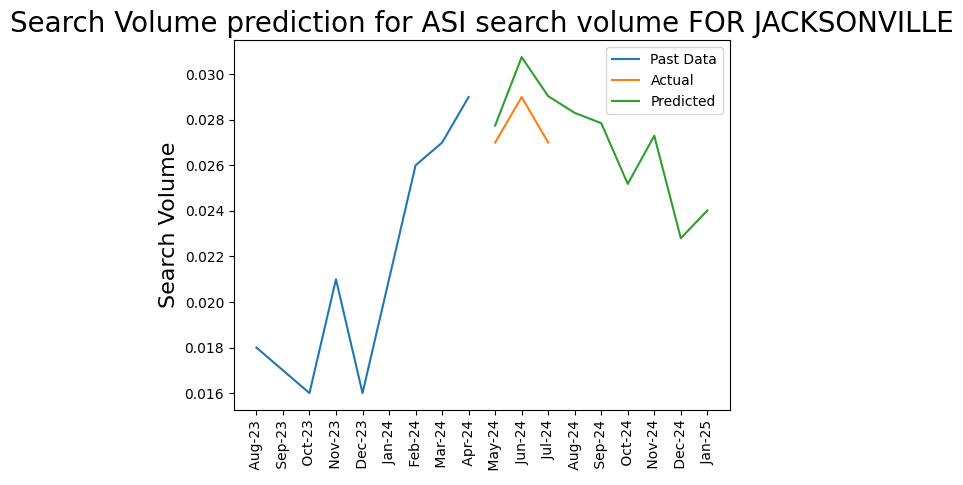

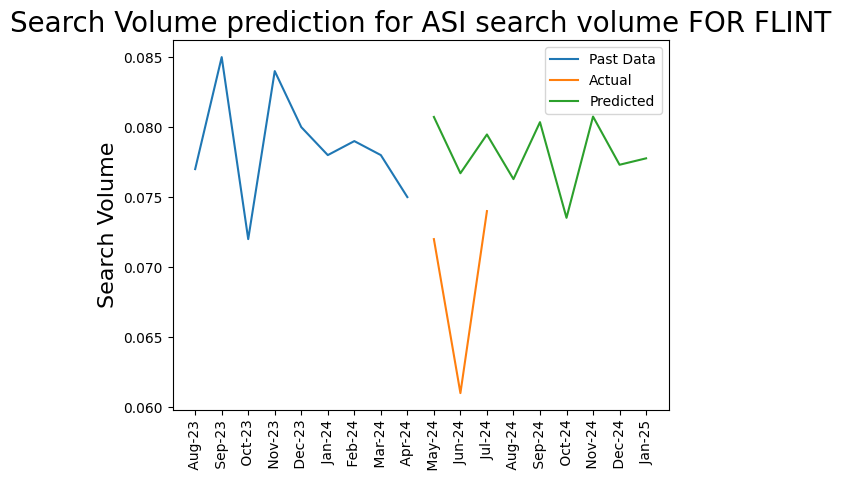

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


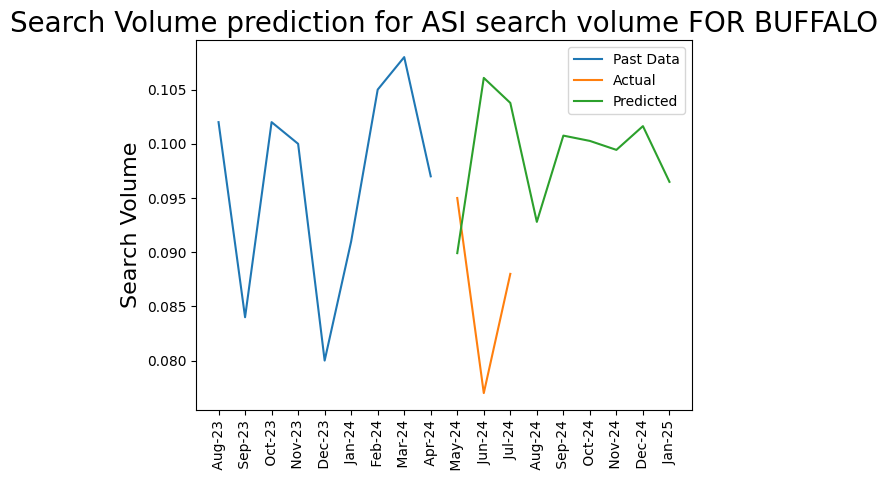

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


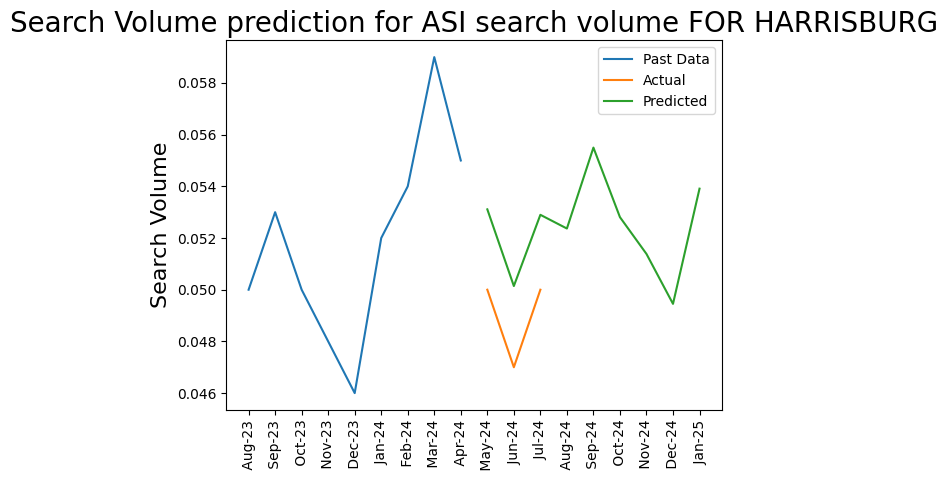

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


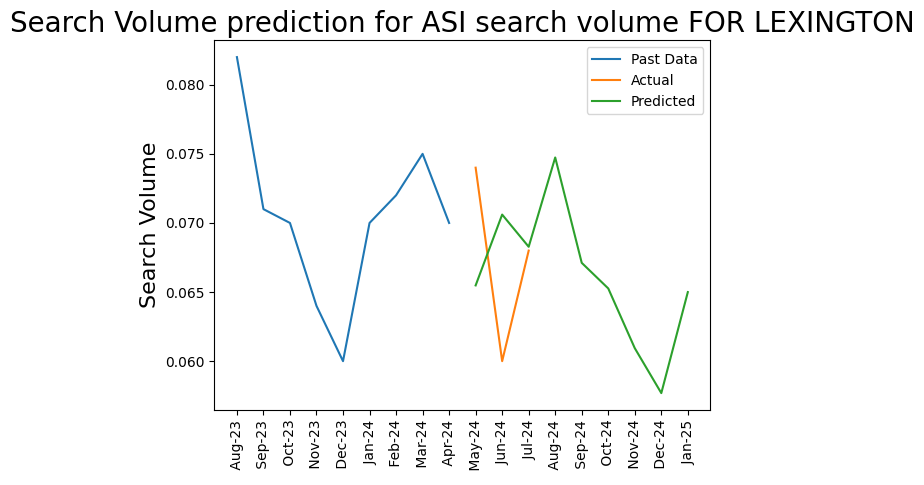

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


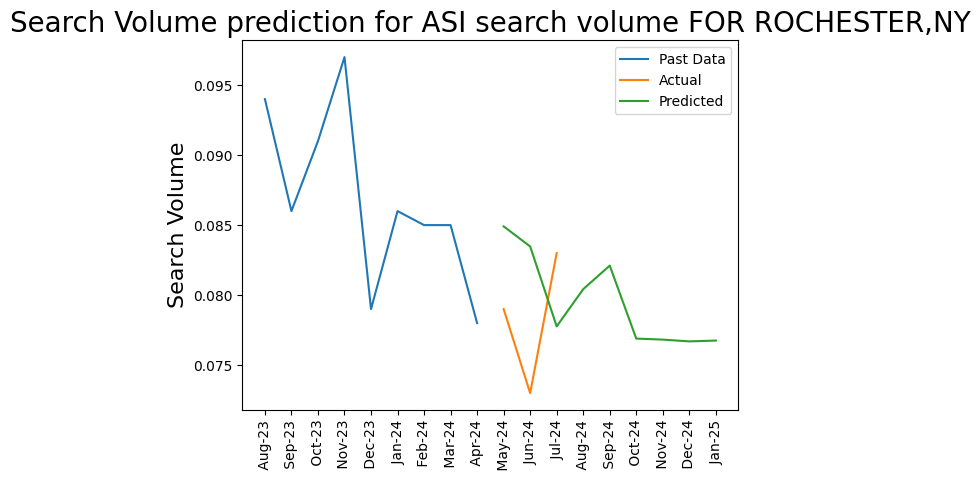

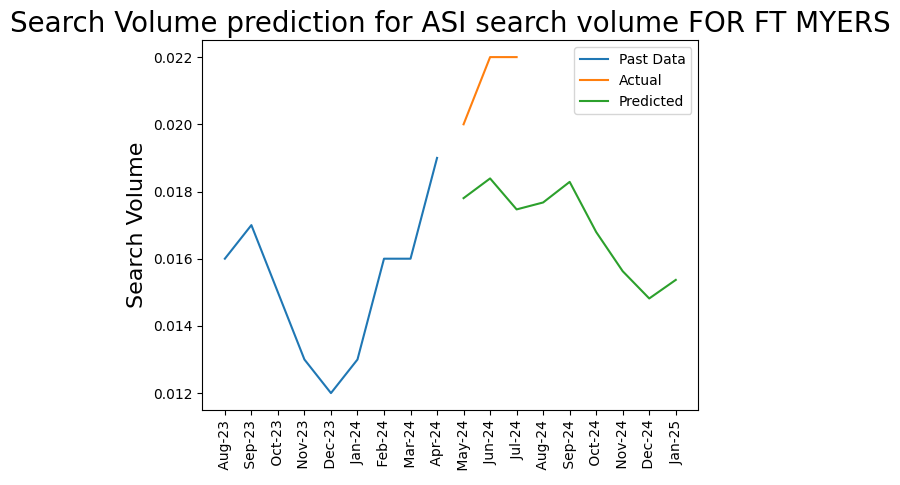

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


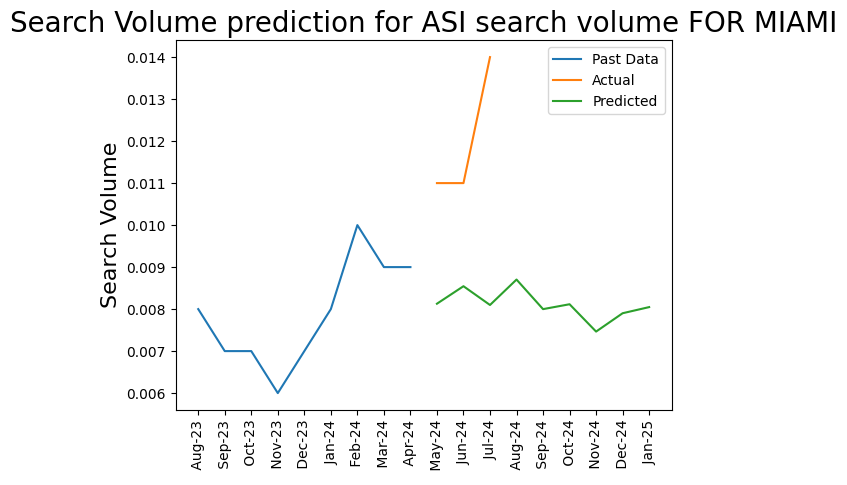

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


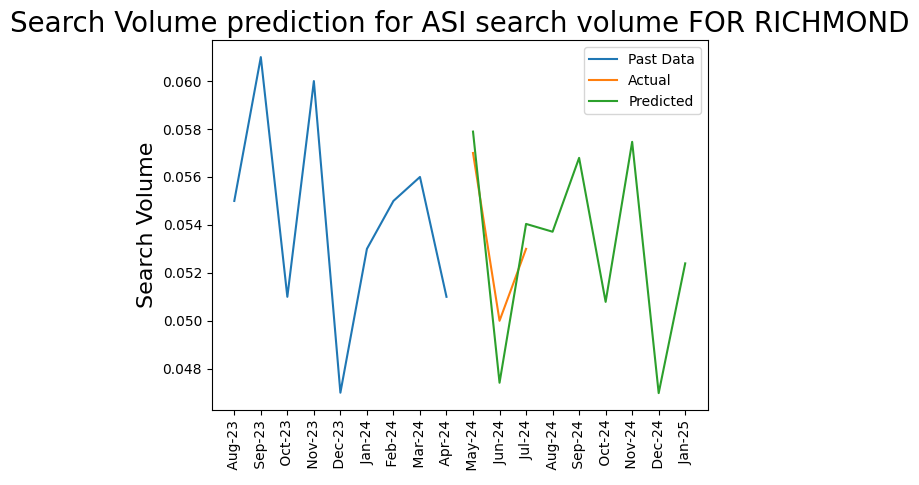

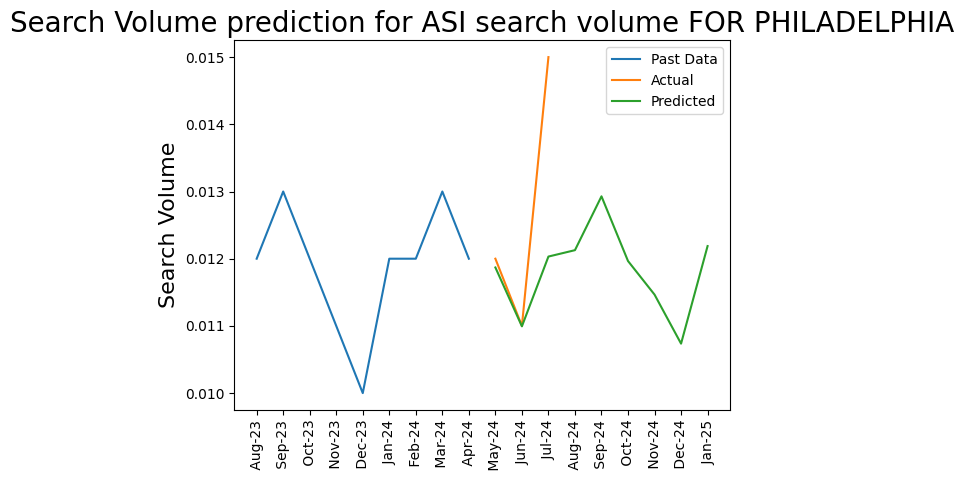

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


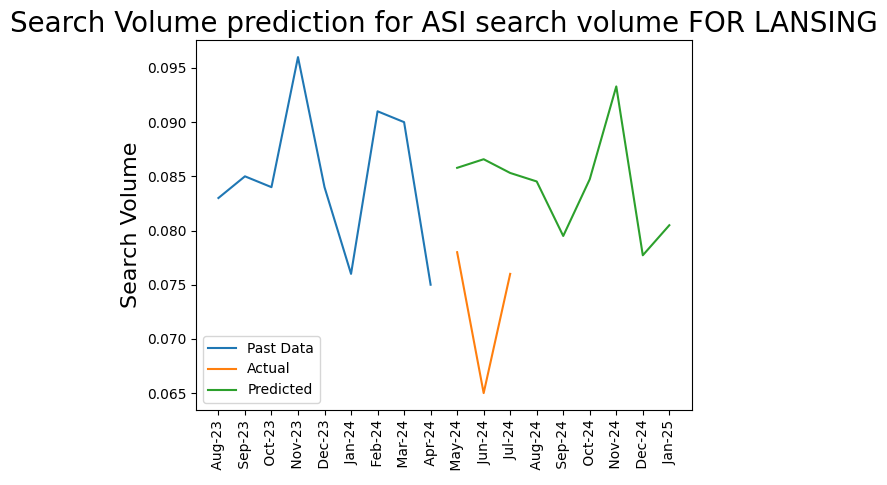

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


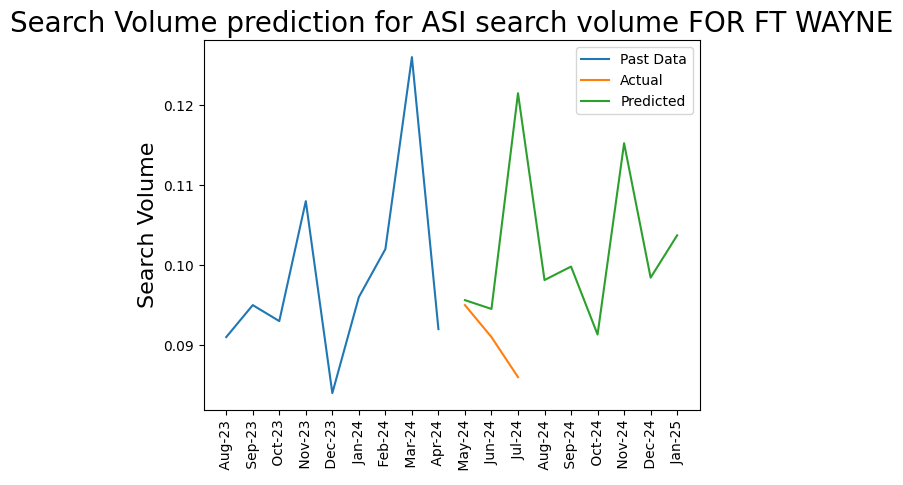

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


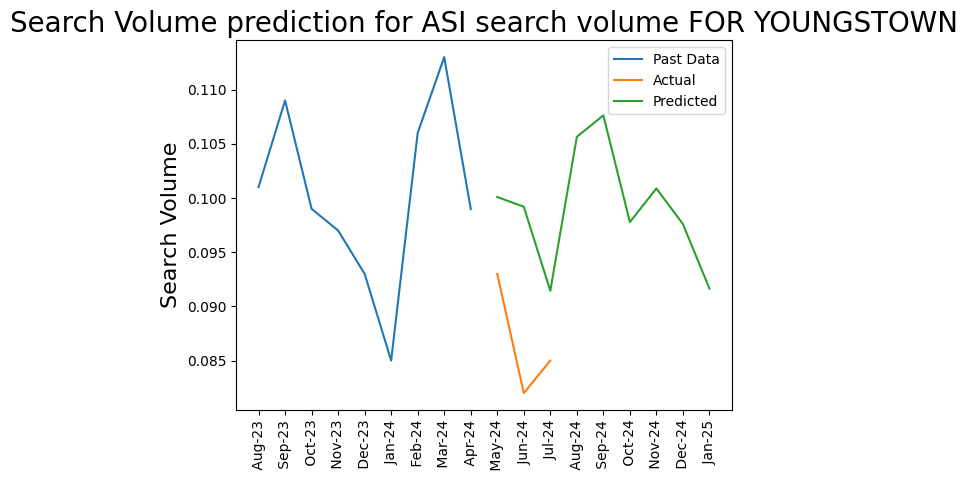

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


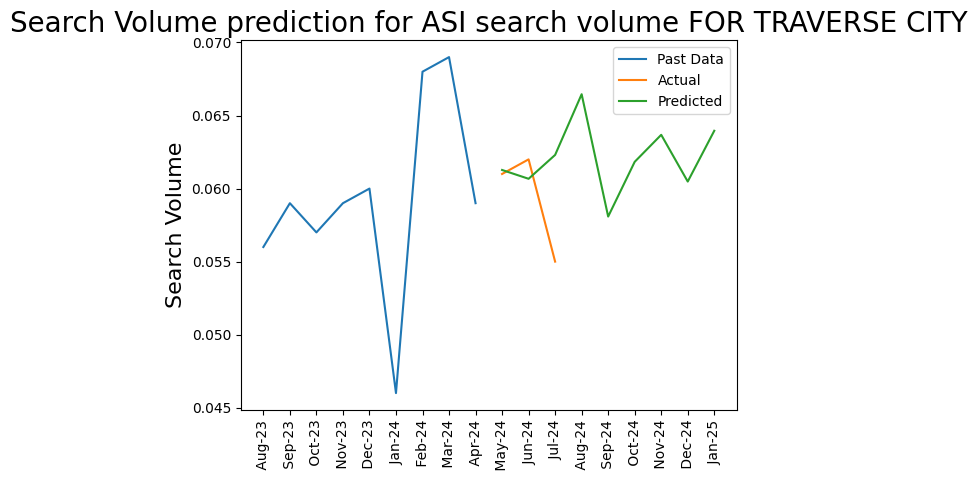

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


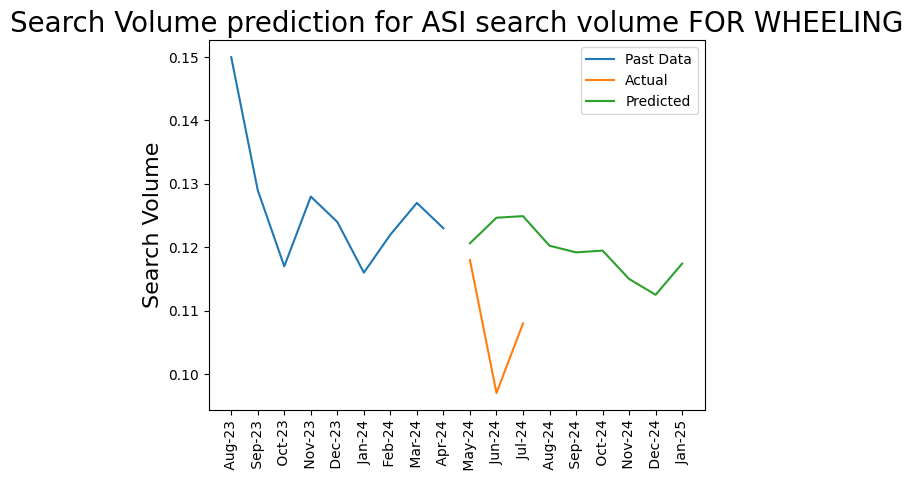

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


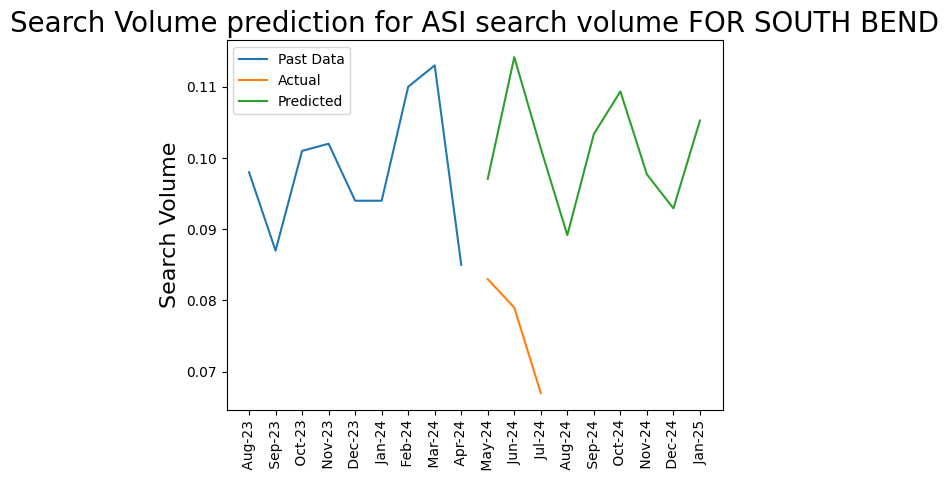

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


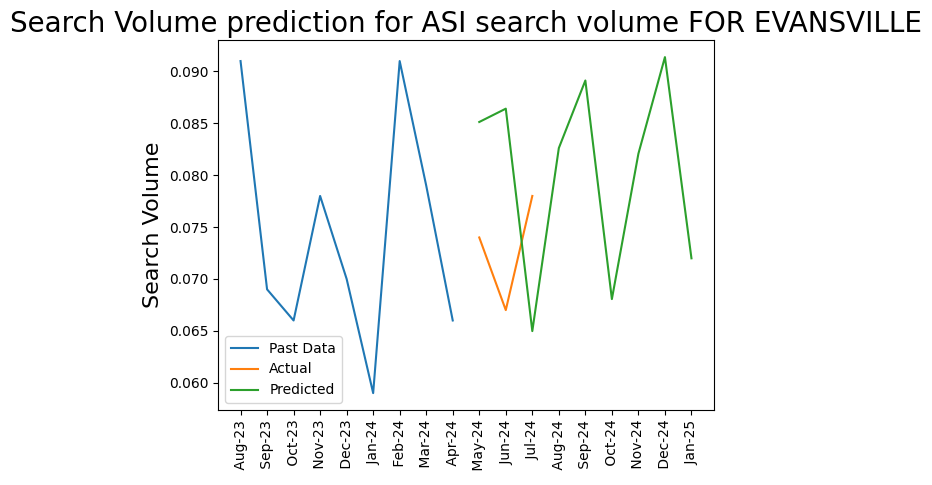

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


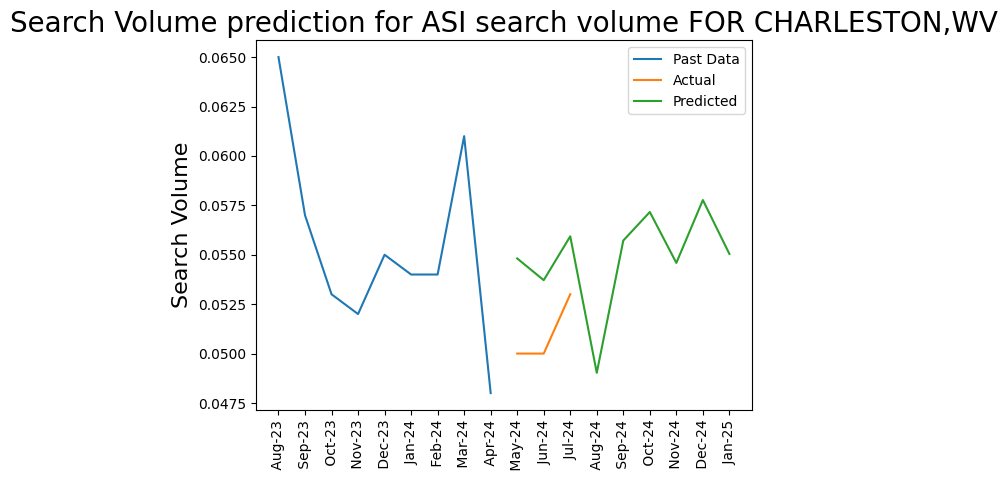

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


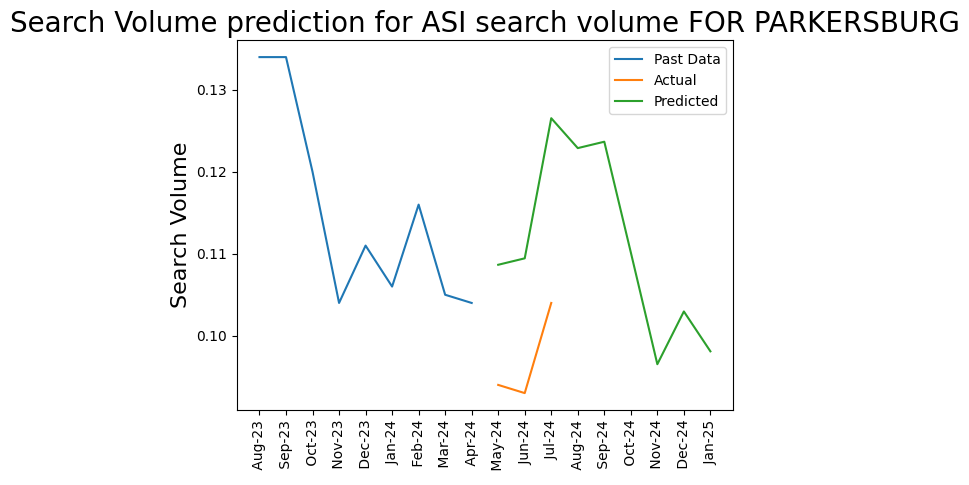

In [17]:
for x in SoS_df.columns:
  sarima = SARIMAX(y_train[x].to_numpy(),
                   order=(6, 0, 2),
                   seasonal_order = (2,0,1,12), # 12 beacause each season is around a year
                   ).fit()
  predictions = sarima.forecast(steps = 9)
  predictions = pd.Series(predictions, index=prediction_times)

  plt.plot(y_train[x], label = "Past Data")
  plt.plot(y_test[x], label="Actual")
  plt.plot(predictions, label="Predicted")
  plt.title('Search Volume prediction for ASI search volume FOR ' + str(x), fontsize=20)
  plt.ylabel('Search Volume', fontsize=16)
  plt.xticks(rotation = 90)
  plt.legend()
  plt.show()